<a href="https://colab.research.google.com/github/KasiaGW/Receptor-Affinity-Prediction-Kaggle-Hackathon-team-project-/blob/main/AGH_ML_Hackathon_Template_20250618.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>Realizacja</b>

## Funkcje uzyte, importy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.stats import chi2_contingency
from itertools import combinations

In [ ]:
from sklearn.linear_model import (
    LinearRegression, Ridge, RidgeCV, SGDRegressor, Lasso, LassoCV, ElasticNet, ElasticNetCV, HuberRegressor
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [ ]:
# Przedstaw summary
# Typy danych
# Dane liczbowe: podstawowe statystyki
# Dane kategoryczne: ilosc unikalnych wartosci
# brakujace wartosci, duplikaty

def profile_data(df):
    pd.set_option('display.float_format', '{:.2f}'.format)
    # Podstawowe informacje
    n_rows, n_cols = df.shape
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    text_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()

    print(f"📊 Profil danych:")
    print(f"➡️ Liczba wierszy: {n_rows}")
    print(f"➡️ Liczba zmiennych: {n_cols}")
    print(f"🔢 Liczba zmiennych numerycznych: {len(num_cols)}")
    print(f"🔤 Liczba zmiennych tekstowych: {len(text_cols)}")
    print(f"🔢 Zmienne numeryczne ({len(num_cols)}): {num_cols}")
    print(f"🔤 Zmienne nienumeryczne ({len(df.columns) - len(num_cols)}): {[col for col in df.columns if col not in num_cols]}")

    # tworzenie profilu
    profile = pd.DataFrame(index=df.columns)

    # Typ danych
    profile["dtype"] = df.dtypes

    # Liczba braków i procent braków
    profile["missing_count"] = df.isnull().sum()
    profile["missing_percent"] = 100 * df.isnull().mean()

    # Liczba unikalnych wartości
    profile["n_unique"] = df.nunique()

    # Najczęstsza wartość
    profile["top_value"] = df.mode().iloc[0]

    # Liczność najczęstszej wartości
    profile["top_freq"] = df.apply(lambda x: x.value_counts().iloc[0] if not x.isnull().all() else None)

    # Statystyki tylko dla kolumn numerycznych
    numeric_cols = df.select_dtypes(include=['number'])
    profile.loc[numeric_cols.columns, "mean"] = numeric_cols.mean()
    profile.loc[numeric_cols.columns, "min"] = numeric_cols.min()
    profile.loc[numeric_cols.columns, "max"] = numeric_cols.max()
    profile.loc[numeric_cols.columns, "25%"] = numeric_cols.quantile(0.25)
    profile.loc[numeric_cols.columns, "50%"] = numeric_cols.median()
    profile.loc[numeric_cols.columns, "75%"] = numeric_cols.quantile(0.75)
    profile.loc[numeric_cols.columns, "std"] = numeric_cols.std()

    # Informacja o duplikatach w całym DataFrame
    n_duplicates = df.duplicated().sum()
    print(f"🔁 Liczba zduplikowanych wierszy: {n_duplicates} ({n_duplicates / len(df) * 100:.2f}%)")

    # Sortowanie: numeryczne, daty, inne
    datetime_cols = df.select_dtypes(include=["datetime"]).columns.tolist()
    other_cols = [col for col in df.columns if col not in num_cols + datetime_cols]
    ordered_cols = num_cols + datetime_cols + other_cols
    profile = profile.loc[ordered_cols]

    return profile.round(2)

In [ ]:
# Wizualizacje
def plot_numerical_grid(df):
    print("Rozklady zmiennych numerycznych.")
    num_cols = df.select_dtypes(include=['number']).columns

    if len(num_cols) == 0:
        print("Brak zmiennych numerycznych.")
        return

    n = len(num_cols)
    ncols = 2
    nrows = math.ceil(n)

    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4 * n))
    axes = axes.reshape(n, 2)

    for i, col in enumerate(num_cols):
        if df[col].dropna().empty:
            axes[i, 0].set_visible(False)
        else:
            sns.histplot(df[col].dropna(), ax=axes[i, 0], kde=True, bins=30)
            axes[i, 0].set_title(f"Histogram: {col}")

        if df[col].dropna().empty:
            axes[i, 1].set_visible(False)
        else:
            sns.boxplot(x=df[col].dropna(), ax=axes[i, 1])
            axes[i, 1].set_title(f"Boxplot: {col}")

    plt.tight_layout()
    plt.show()

In [ ]:
# Feature importance
def plot_feature_importance(model, model_name, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10,5))
    plt.title(f"Ważność cech: {model_name}")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
# Funkcja do metryk
def print_regression_metrics(y_true, y_pred, model_name="Model"):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"Metryki dla {model_name}:")
    print(f"  R2:    {r2:.4f}")
    print(f"  RMSE:  {rmse:.4f}")
    print(f"  MAPE:  {mape:.4f}")
    print()

## Pobranie i przygotowanie danych

Pobranie danych, zrozumienie struktury, polaczenie danych ZINC i CHEMBL (usuniecie duplikatow - pierwszenstwo ZINC), pobranie deskryptorow z bazy, sprawdzenie brakujacych wartosci, dobor deskryptorow.

In [ ]:
# pobranie i rozpakowanie danych na dysk google
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c receptor-affinity-prediction-hackaton
!unzip -q receptor-affinity-prediction-hackaton.zip

Saving kaggle.json to kaggle.json
  0% 0.00/59.9M [00:00<?, ?B/s]
100% 59.9M/59.9M [00:00<00:00, 991MB/s]


In [ ]:
# wczytanie ZINC i CHEMBL
zinc_raw = pd.read_csv('ZINC_data_5HT2A.csv')
chembl_raw = pd.read_csv('Chembl_data_5HT2A.csv')

In [ ]:
# kolumny potrzebne do dalszych operacji
zinc = zinc_raw.copy()
zinc = zinc[['zinc_id', 'smiles', 'pKi_numeric']]
chembl = chembl_raw.copy()
chembl = chembl[['Smiles', 'pKi_numeric', 'Standard Type', 'Standard Relation', 'Standard Value']]

In [ ]:
# chembl : odfiltrowac relation == '=' [inne maja dane brakujace lub niedokladne]
chembl = chembl.loc[chembl['Standard Relation'] == "'='"]

In [ ]:
# obliczamy PKI wedlug wzoru
chembl['PKI'] = -np.log10(chembl['Standard Value'] / 1e9)

In [ ]:
# wyswietl duplikaty na Smiles
chembl[chembl.duplicated(subset=['Smiles', 'PKI'], keep=False)].sort_values(by='Smiles')

,Smiles,pKi_numeric,Standard Type,Standard Relation,Standard Value,PKI
4836,C1=CC2CNCCN3C[C@@H]4CCC[C@@H]4C(=C1)C23,6.83,Ki,'=',149.00,6.826814
2952,C1=CC2CNCCN3C[C@@H]4CCC[C@@H]4C(=C1)C23,6.83,Ki,'=',149.00,6.826814
2437,CC(N)Cc1c2c(c(Br)c3c1OCC3)OCC2,9.32,Ki,'=',0.48,9.318759
250,CC(N)Cc1c2c(c(Br)c3c1OCC3)OCC2,9.32,Ki,'=',0.48,9.318759
1199,CC1(CN)c2ccccc2Cc2ccccc21,7.19,Ki,'=',65.00,7.187087
...,...,...,...,...,...,...
2923,c1ccc(-c2nc3cc(CCN4CCN(c5ccccc5)CC4)ccc3[nH]2)cc1,6.12,Ki,'=',758.58,6.119999
2928,c1ccc(CNCC2c3ccccc3Cc3ccccc32)cc1,6.14,Ki,'=',721.00,6.142065
2378,c1ccc(CNCC2c3ccccc3Cc3ccccc32)cc1,6.14,Ki,'=',721.00,6.142065
2825,c1ccc2c(N3CCN(CCc4ccc5[nH]nnc5c4)CC3)cccc2c1,7.98,Ki,'=',10.47,7.980053


In [ ]:
chembl.loc[chembl['pKi_numeric'] != chembl['PKI']]

,Smiles,pKi_numeric,Standard Type,Standard Relation,Standard Value,PKI
0,CC(=O)c1c(OCCCCN2CCN(c3cccc(F)c3)CC2)ccc2c(C)c...,6.40,Ki,'=',400.000,6.397940
1,COc1c2c(c(CCN)c3c1OCC3)CCO2,5.35,Ki,'=',4443.000,5.352324
2,COc1ccc2[nH]cc(CCNCc3ccc(-c4cn[nH]c4)o3)c2c1,7.55,Ki,'=',28.000,7.552842
3,Oc1ccc(-c2ccc(CNCCc3c[nH]c4cc(F)ccc34)o2)cc1,7.02,Ki,'=',96.000,7.017729
4,O=C(NC/C=C/CN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccc(-c2...,7.21,Ki,'=',62.400,7.204815
...,...,...,...,...,...,...
5447,CCNCc1ccc(Cl)c(-c2ccccc2OC)c1,6.04,Ki,'=',910.000,6.040959
5448,C[C@H]1C[C@H](NS(=O)(=O)c2cc3ccc(Cl)cc3s2)CN1C...,8.38,Ki,'=',4.169,8.379968
5449,CC(=O)Nc1ccc(OCCCN2CCC(c3noc4cc(F)ccc34)CC2)cc1F,7.38,Ki,'=',41.800,7.378824
5450,OCCOCCN1CCN(C2=Nc3ccccc3Sc3ccccc32)CC1,6.92,Ki,'=',120.230,6.919987


In [ ]:
# duplikaty: 1. usuwamy duplikaty gdzie Smiles i PKI sa identyczne [zostawiamy pierwszy]
# duplikaty: 2. usuwamy wszystkie pary rekordow, gdzie Smiles jest ten sam, ale PKI jest rozne
chembl_clean = chembl.drop_duplicates(subset=['Smiles', 'PKI'], keep='first')
chembl_clean = chembl_clean.drop_duplicates(subset=['Smiles'], keep=False)

In [ ]:
profile_data(chembl_clean)

📊 Profil danych:
➡️ Liczba wierszy: 3141
➡️ Liczba zmiennych: 6
🔢 Liczba zmiennych numerycznych: 3
🔤 Liczba zmiennych tekstowych: 3
🔢 Zmienne numeryczne (3): ['pKi_numeric', 'Standard Value', 'PKI']
🔤 Zmienne nienumeryczne (3): ['Smiles', 'Standard Type', 'Standard Relation']
🔁 Liczba zduplikowanych wierszy: 0 (0.00%)


,dtype,missing_count,missing_percent,n_unique,top_value,top_freq,mean,min,max,25%,50%,75%,std
pKi_numeric,float64,2,0.06,492,6.40,32,7.27,4.00,11.00,6.37,7.28,8.09,1.16
Standard Value,float64,0,0.00,1655,398.11,25,32737.69,0.01,100000000.00,8.15,53.00,433.00,1784282.54
PKI,float64,0,0.00,1655,6.20,25,7.27,1.00,11.00,6.36,7.28,8.09,1.17
Smiles,object,0,0.00,3141,Br.Cc1cccc(-c2c(O)c(O)cc3c2CCN(C)CC3c2cccc(C)c...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Standard Type,object,0,0.00,1,Ki,3141,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Standard Relation,object,0,0.00,1,'=',3141,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# polaczyc zinc i chembl:
# dodac zinc_id = 'chembl' do chembl, zeby je zaznaczyc
# dostosuj nazwy kolumn
# odfiltruj smiles z chembl_clean, ktore sa juz w ZINC

chembl_clean['zinc_id'] = 'chembl'
chembl_clean.rename(columns={'Smiles': 'smiles'}, inplace=True)
zinc.rename(columns={'pKi_numeric': 'PKI'}, inplace=True)
chembl_clean = chembl_clean.loc[~chembl_clean['smiles'].isin(zinc['smiles'])]

zinc_chembl = pd.concat([zinc[['zinc_id', 'smiles', 'PKI']], chembl_clean[['zinc_id', 'smiles', 'PKI']]])

In [ ]:
zinc_chembl[zinc_chembl.duplicated(subset=['smiles'], keep=False)].sort_values(by='smiles')

,zinc_id,smiles,PKI


In [ ]:
profile_data(zinc_chembl)

📊 Profil danych:
➡️ Liczba wierszy: 4887
➡️ Liczba zmiennych: 3
🔢 Liczba zmiennych numerycznych: 1
🔤 Liczba zmiennych tekstowych: 2
🔢 Zmienne numeryczne (1): ['PKI']
🔤 Zmienne nienumeryczne (2): ['zinc_id', 'smiles']
🔁 Liczba zduplikowanych wierszy: 0 (0.00%)


,dtype,missing_count,missing_percent,n_unique,top_value,top_freq,mean,min,max,25%,50%,75%,std
PKI,float64,0,0.00,1731,6.00,46,7.18,1.00,11.00,6.32,7.10,7.94,1.15
zinc_id,object,0,0.00,2878,chembl,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smiles,object,0,0.00,4887,Br.Cc1cccc(-c2c(O)c(O)cc3c2CCN(C)CC3c2cccc(C)c...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
smiles = zinc_chembl[['smiles', 'PKI']]

In [ ]:
# pobrac deskryptory dla naszych smiles
# wczytaj deskryptory
# zmerguj df smiles i deskryptory

deskryptory = pd.read_csv('Mordred_descriptors_database.csv')


/tmp/ipython-input-22-2580666367.py:5: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,54,55,56,57,58,59,60,61,62,136,137,138,139,140,141,142,145,146,147,148,149,150,151,153,154,155,156,157,158,159,160,163,164,165,166,167,168,169,172,173,174,175,176,177,178,181,182,183,184,185,186,187,190,191,192,193,194,195,196,199,200,201,202,203,204,205,208,209,210,211,212,213,214,217,218,219,220,221,222,223,226,227,228,229,230,231,232,234,235,236,237,238,239,240,241,242,261,262,263,264,265,266,267,268,269,342,343,344,345,346,347,348,349,352,353,354,355,356,357,358,361,362,363,364,365,366,367,369,370,371,372,373,374,375,376,379,380,381,382,383,384,385,388,389,390,391,392,393,394,397,398,399,400,401,402,403,406,407,408,409,410,411,412,415,416,417,418,419,420,421,424,425,426,427,428,429,430,433,434,435,436,437,438,439,442,443,444,445,446,447,448,450,451,452,453,454,455,456,458,459,460,461,462,463,464,466,467,468,469,470,471,472,474,475,476,477,478,479,480,482,483,484,485,486,487,488,490,491,492,

In [ ]:
smiles.shape

(4887, 2)

In [ ]:
deskryptory.shape

(7009, 1614)

In [ ]:
raw_data = pd.merge(smiles, deskryptory, on='smiles', how='left')

In [ ]:
raw_data.shape

(4887, 1615)

In [ ]:
raw_data.to_csv('raw_data.csv', index=False)

In [ ]:
missing = raw_data.isna().sum()

In [ ]:
# nie ma brakujacych wartosci
missing.loc[missing > 0]

,0


In [ ]:
# Sprawdzamy czy sa zmienne niezmienne
nunique = raw_data.nunique()

In [ ]:
nunique.loc[nunique == 1]

,0
ABC,1
ABCGG,1
nB,1
NsLi,1
NssBe,1
...,...
n11FaHRing,1
n4FARing,1
n5FARing,1
n4FAHRing,1


In [ ]:
# usun kolumny z ta sama wartoscia w kazdym wierszu
cols_to_drop = nunique.loc[nunique == 1].index.tolist()
raw_data_2 = raw_data.drop(columns=cols_to_drop)

In [ ]:
raw_data_2.shape

(4887, 1390)

In [ ]:
profile_data(raw_data_2)

📊 Profil danych:
➡️ Liczba wierszy: 4887
➡️ Liczba zmiennych: 1390
🔢 Liczba zmiennych numerycznych: 631
🔤 Liczba zmiennych tekstowych: 757
🔢 Zmienne numeryczne (631): ['PKI', 'nAcid', 'nBase', 'nAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom', 'nSpiro', 'nBridgehead', 'nHetero', 'nH', 'nC', 'nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'nX', 'ATS0dv', 'ATS1dv', 'ATS2dv', 'ATS3dv', 'ATS4dv', 'ATS5dv', 'ATS6dv', 'ATS7dv', 'ATS8dv', 'ATS0d', 'ATS1d', 'ATS2d', 'ATS3d', 'ATS4d', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS8d', 'ATS0Z', 'ATS1Z', 'ATS2Z', 'ATS3Z', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS7Z', 'ATS8Z', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0se', 'ATS1se', 'ATS2se', 'ATS3se', 'ATS4se', 'ATS5se', 'ATS6se', 'ATS7se', 'ATS8se', 'ATS0pe', 'ATS1pe', 'ATS2pe', 'ATS3pe', 'ATS4pe', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS8pe', 'ATS0are', 'ATS1are', 'ATS2are', 'ATS3are', 'ATS4are', 'ATS5

/tmp/ipython-input-5-2461157667.py:36: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  profile["top_value"] = df.mode().iloc[0]


🔁 Liczba zduplikowanych wierszy: 0 (0.00%)


,dtype,missing_count,missing_percent,n_unique,top_value,top_freq,mean,min,max,25%,50%,75%,std
PKI,float64,0,0.00,1731,6.00,46,7.18,1.00,11.00,6.32,7.10,7.94,1.15
nAcid,int64,0,0.00,3,0.00,4743,0.03,0.00,2.00,0.00,0.00,0.00,0.18
nBase,int64,0,0.00,6,1.00,4354,0.99,0.00,5.00,1.00,1.00,1.00,0.39
nAromAtom,int64,0,0.00,24,12.00,1386,12.82,0.00,30.00,9.00,12.00,16.00,4.42
nAromBond,int64,0,0.00,22,12.00,1370,13.24,0.00,30.00,10.00,12.00,17.00,4.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMID_X,object,0,0.00,1582,0.0,1717,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RotRatio,object,0,0.00,348,0.00,188,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vabc,object,0,0.00,3025,unknown atom type (Vabc),40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VAdjMat,object,0,0.00,85,6.21,273,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# zostawiamy tylko zmienne wczytane jako numeryczne, oznacza to, ze nie bylo bledow i brakow w wyliczeniu tych deskryptorow
# zmienne wczytane jako str > brakujace wartosci liczbowe zostaly zastapione tekstem zawierajacym opis bledu
# i zrozumiane przez pandas jako tekst > faktycznie zawieraja brakujace wartosci
num_cols = raw_data_2.select_dtypes(include=['number']).columns.tolist()
raw_data_num = raw_data_2[num_cols + ['smiles']]

In [ ]:
profile_data(raw_data_num)

📊 Profil danych:
➡️ Liczba wierszy: 4887
➡️ Liczba zmiennych: 632
🔢 Liczba zmiennych numerycznych: 631
🔤 Liczba zmiennych tekstowych: 1
🔢 Zmienne numeryczne (631): ['PKI', 'nAcid', 'nBase', 'nAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom', 'nSpiro', 'nBridgehead', 'nHetero', 'nH', 'nC', 'nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'nX', 'ATS0dv', 'ATS1dv', 'ATS2dv', 'ATS3dv', 'ATS4dv', 'ATS5dv', 'ATS6dv', 'ATS7dv', 'ATS8dv', 'ATS0d', 'ATS1d', 'ATS2d', 'ATS3d', 'ATS4d', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS8d', 'ATS0Z', 'ATS1Z', 'ATS2Z', 'ATS3Z', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS7Z', 'ATS8Z', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0se', 'ATS1se', 'ATS2se', 'ATS3se', 'ATS4se', 'ATS5se', 'ATS6se', 'ATS7se', 'ATS8se', 'ATS0pe', 'ATS1pe', 'ATS2pe', 'ATS3pe', 'ATS4pe', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS8pe', 'ATS0are', 'ATS1are', 'ATS2are', 'ATS3are', 'ATS4are', 'ATS5are

,dtype,missing_count,missing_percent,n_unique,top_value,top_freq,mean,min,max,25%,50%,75%,std
PKI,float64,0,0.00,1731,6.00,46,7.18,1.00,11.00,6.32,7.10,7.94,1.15
nAcid,int64,0,0.00,3,0.00,4743,0.03,0.00,2.00,0.00,0.00,0.00,0.18
nBase,int64,0,0.00,6,1.00,4354,0.99,0.00,5.00,1.00,1.00,1.00,0.39
nAromAtom,int64,0,0.00,24,12.00,1386,12.82,0.00,30.00,9.00,12.00,16.00,4.42
nAromBond,int64,0,0.00,22,12.00,1370,13.24,0.00,30.00,10.00,12.00,17.00,4.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
WPol,int64,0,0.00,78,48.00,223,44.03,7.00,126.00,36.00,45.00,52.00,11.77
Zagreb1,float64,0,0.00,105,166.00,170,147.27,38.00,362.00,122.00,154.00,174.00,36.55
Zagreb2,float64,0,0.00,217,192.00,101,174.38,40.00,445.00,145.00,182.00,205.00,43.97
mZagreb2,float64,0,0.00,971,4.89,47,6.03,2.21,15.78,4.97,6.26,7.06,1.45


In [ ]:
raw_data_num.to_csv('raw_data_num.csv', index=False)

Rozklady zmiennych numerycznych.


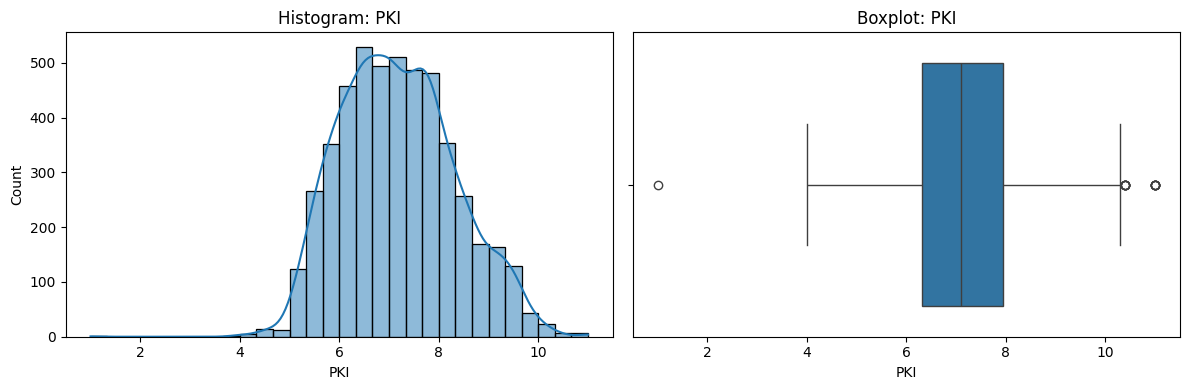

In [ ]:
plot_numerical_grid(raw_data_num[['PKI', 'smiles']])

## Przygotowanie danych do modelu

In [ ]:
# przygotowanie danych do modelu

y = raw_data_num['PKI']
X = raw_data_num.drop(columns=['PKI', 'smiles'])

# Podział
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42)


# Pipeline dla danych numerycznych
preprocessor = StandardScaler()

X_train_transformed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_transformed = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

In [ ]:
import joblib
# 2. Zapis do pliku
joblib.dump(preprocessor, "preprocessor_scaler.pkl")

['preprocessor_scaler.pkl']

## REGRESJA - Trening modeli

In [ ]:
# Tworzenie modeli - liniowe
regr = LinearRegression()
ridge = Ridge()
ridgeCV = RidgeCV()
SGDregr = SGDRegressor(max_iter=1000, tol=1e-3)
lasso = Lasso()
lassoCV = LassoCV()
elastic = ElasticNet()
elasticCV = ElasticNetCV()
huber = HuberRegressor()

In [ ]:
# Trenowanie modeli - liniowe
regr.fit(X_train_transformed, y_train)
ridge.fit(X_train_transformed, y_train)
ridgeCV.fit(X_train_transformed, y_train)
SGDregr.fit(X_train_transformed, y_train)
lasso.fit(X_train_transformed, y_train)
lassoCV.fit(X_train_transformed, y_train)
elastic.fit(X_train_transformed, y_train)
elasticCV.fit(X_train_transformed, y_train)
huber.fit(X_train_transformed, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5134901717924549, tolerance: 0.4126692140128152
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7654711539439631, tolerance: 0.4126692140128152
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7593775333293706, tolerance: 0.4126692140128152
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Converge

HuberRegressor()

In [ ]:
# Predykcje na X_test - liniowe
y_pred_regr = regr.predict(X_test_transformed)
y_pred_ridge = ridge.predict(X_test_transformed)
y_pred_ridgeCV = ridgeCV.predict(X_test_transformed)
y_pred_SGD = SGDregr.predict(X_test_transformed)
y_pred_lasso = lasso.predict(X_test_transformed)
y_pred_lassoCV = lassoCV.predict(X_test_transformed)
y_pred_elastic = elastic.predict(X_test_transformed)
y_pred_elasticCV = elasticCV.predict(X_test_transformed)
y_pred_huber = huber.predict(X_test_transformed)

In [ ]:
# Metryki modeli liniowych
print_regression_metrics(y_test, y_pred_regr, "LinearRegression")
print_regression_metrics(y_test, y_pred_ridge, "Ridge")
print_regression_metrics(y_test, y_pred_ridgeCV, "RidgeCV")
print_regression_metrics(y_test, y_pred_SGD, "SGDRegressor")
print_regression_metrics(y_test, y_pred_lasso, "Lasso")
print_regression_metrics(y_test, y_pred_lassoCV, "LassoCV")
print_regression_metrics(y_test, y_pred_elastic, "ElasticNet")
print_regression_metrics(y_test, y_pred_elasticCV, "ElasticNetCV")
print_regression_metrics(y_test, y_pred_huber, "HuberRegressor")

Metryki dla LinearRegression:
  R2:    -4025.5590
  RMSE:  73.8111
  MAPE:  0.6941

Metryki dla Ridge:
  R2:    0.4636
  RMSE:  0.8519
  MAPE:  0.0889

Metryki dla RidgeCV:
  R2:    0.4581
  RMSE:  0.8563
  MAPE:  0.0897

Metryki dla SGDRegressor:
  R2:    -70367072515259107377152.0000
  RMSE:  308559884795.3343
  MAPE:  4971124960.0171

Metryki dla Lasso:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla LassoCV:
  R2:    0.4518
  RMSE:  0.8612
  MAPE:  0.0897

Metryki dla ElasticNet:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla ElasticNetCV:
  R2:    0.4539
  RMSE:  0.8596
  MAPE:  0.0897

Metryki dla HuberRegressor:
  R2:    0.4089
  RMSE:  0.8943
  MAPE:  0.0905



In [ ]:
# Tworzenie modeli - XGBoost
""" Pierwsza wersja XGBRegressor:
xgb_regr = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,        # liczba drzew (większa = mocniejsze, wolniejsze)
    learning_rate=0.1,       # tempo uczenia (mniejsze = wolniejsze ale bardziej dokładne)
    max_depth=3,             # maksymalna głębokość drzewa (większa = bardziej skomplikowany model)
    subsample=0.8,           # procent próbek używanych w każdym drzewie (np. 0.8)
    colsample_bytree=0.8,    # procent kolumn używanych w każdym drzewie
    reg_alpha=0.0,           # L1 regularizacja (więcej = bardziej "zeruje" cechy)
    reg_lambda=1.0,          # L2 regularizacja (więcej = bardziej "karze" duże wagi)
    random_state=42          # dla powtarzalności
)
R2 = 0.57
"""

xgb_regr = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,        # liczba drzew (większa = mocniejsze, wolniejsze)
    learning_rate=0.01,       # tempo uczenia (mniejsze = wolniejsze ale bardziej dokładne)
    max_depth=10,             # maksymalna głębokość drzewa (większa = bardziej skomplikowany model)
    subsample=0.8,           # procent próbek używanych w każdym drzewie (np. 0.8)
    colsample_bytree=0.8,    # procent kolumn używanych w każdym drzewie
    reg_alpha=0.0,           # L1 regularizacja (więcej = bardziej "zeruje" cechy)
    reg_lambda=1.0,          # L2 regularizacja (więcej = bardziej "karze" duże wagi)
    random_state=42          # dla powtarzalności
)

In [ ]:
# Trenowanie modeli - XGBoost
xgb_regr.fit(X_train_transformed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predykcje na X_test - XGBoost
y_pred_xgb = xgb_regr.predict(X_test_transformed)

In [ ]:
# Metryki XGBOOST
print_regression_metrics(y_test, y_pred_xgb, "XGBRegressor")

Metryki dla XGBRegressor:
  R2:    0.7103
  RMSE:  0.6261
  MAPE:  0.0579



In [ ]:
import joblib
# 2. Zapis do pliku
joblib.dump(xgb_regr, "xgboost_regressor.pkl")

['xgboost_regressor.pkl']

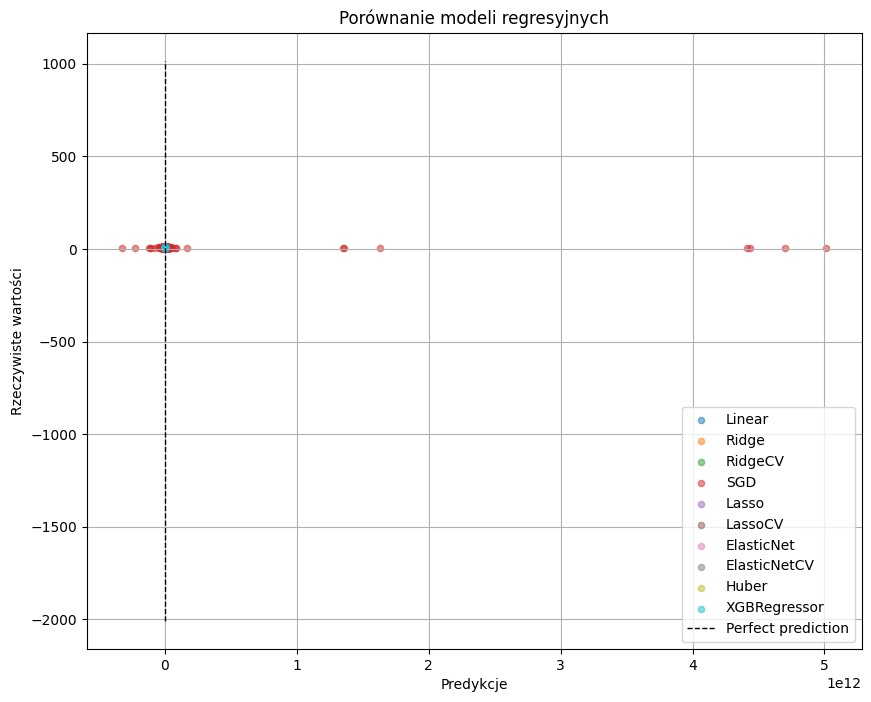

In [ ]:
# Wizualizacja
plt.figure(figsize=(10, 8))

# Dodaj każdy model jako osobny scatter
plt.scatter(regr.predict(X_test_transformed), y_test, alpha=0.5, label='Linear', s=20)
plt.scatter(ridge.predict(X_test_transformed), y_test, alpha=0.5, label='Ridge', s=20)
plt.scatter(ridgeCV.predict(X_test_transformed), y_test, alpha=0.5, label='RidgeCV', s=20)
plt.scatter(SGDregr.predict(X_test_transformed), y_test, alpha=0.5, label='SGD', s=20)
plt.scatter(lasso.predict(X_test_transformed), y_test, alpha=0.5, label='Lasso', s=20)
plt.scatter(lassoCV.predict(X_test_transformed), y_test, alpha=0.5, label='LassoCV', s=20)
plt.scatter(elastic.predict(X_test_transformed), y_test, alpha=0.5, label='ElasticNet', s=20)
plt.scatter(elasticCV.predict(X_test_transformed), y_test, alpha=0.5, label='ElasticNetCV', s=20)
plt.scatter(huber.predict(X_test_transformed), y_test, alpha=0.5, label='Huber', s=20)
plt.scatter(xgb_regr.predict(X_test_transformed), y_test, alpha=0.5, label='XGBRegressor', s=20)

# Linia idealnego dopasowania
min_val = min(y_test.min(), regr.predict(X_test_transformed).min())
max_val = max(y_test.max(), regr.predict(X_test_transformed).max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label='Perfect prediction')

plt.xlabel('Predykcje')
plt.ylabel('Rzeczywiste wartości')
plt.title('Porównanie modeli regresyjnych')
plt.legend()
plt.grid(True)
plt.show()

## REGRESJA - Usprawnienia modeli

### Eliminacja wsteczna cech nieistotnych

In [ ]:
# Eliminacja wsteczna cech nieistotnych

import statsmodels.api as sm

X_train_ols = X_train.copy()
X_train_ols = X_train_ols.values
X_train_ols = sm.add_constant(X_train_ols)

In [ ]:
X_train_numpy = X_train.values
X_train_numpy = sm.add_constant(X_train_numpy)
num_vars = len(X_train_numpy[0])
predictors = ['const'] + list(X_train.columns)
sl = 0.05
for i in range(0, num_vars):
  ols = sm.OLS(endog=y_train, exog=X_train_numpy).fit()
  max_pval = max(ols.pvalues.astype('float'))
  if max_pval > sl:
    for j in range(0, num_vars - i):
      if ols.pvalues[j].astype('float') == max_pval:
        X_train_numpy = np.delete(X_train_numpy, j, axis=1)
        predictors.remove(predictors[j])
print(ols.summary(xname=predictors))

KeyboardInterrupt: 

In [ ]:
len(predictors)

"""
# wykluczenie predyktorow (pozostawienie tylko tych z listy predictors nie poprawilo wynikow):
Metryki dla LinearRegression:
  R2:    0.2956
  RMSE:  0.9762
  MAPE:  0.0932

Metryki dla Ridge:
  R2:    0.4552
  RMSE:  0.8586
  MAPE:  0.0900

Metryki dla RidgeCV:
  R2:    0.4377
  RMSE:  0.8723
  MAPE:  0.0899

Metryki dla SGDRegressor:
  R2:    -2599476720484617216.0000
  RMSE:  1875416308.2780
  MAPE:  185898181.3238

Metryki dla Lasso:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla LassoCV:
  R2:    0.4532
  RMSE:  0.8601
  MAPE:  0.0904

Metryki dla ElasticNet:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla ElasticNetCV:
  R2:    0.4520
  RMSE:  0.8610
  MAPE:  0.0905

Metryki dla HuberRegressor:
  R2:    0.3952
  RMSE:  0.9046
  MAPE:  0.0918

Metryki dla XGBRegressor:
  R2:    0.5598
  RMSE:  0.7718
  MAPE:  0.0839
  """

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

"""
xgb_regr = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,        # liczba drzew (większa = mocniejsze, wolniejsze)
    learning_rate=0.01,       # tempo uczenia (mniejsze = wolniejsze ale bardziej dokładne)
    max_depth=10,             # maksymalna głębokość drzewa (większa = bardziej skomplikowany model)
    subsample=0.8,           # procent próbek używanych w każdym drzewie (np. 0.8)
    colsample_bytree=0.8,    # procent kolumn używanych w każdym drzewie
    reg_alpha=0.0,           # L1 regularizacja (więcej = bardziej "zeruje" cechy)
    reg_lambda=1.0,          # L2 regularizacja (więcej = bardziej "karze" duże wagi)
    random_state=42          # dla powtarzalności
)
"""
"""
Najlepsze parametry: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1500} z Grid Search
Metryki dla Best XGBoostReg:
  R2:    0.7166
  RMSE:  0.6192
  MAPE:  0.0575
  """


from sklearn.model_selection import GridSearchCV

xgb_gpu = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',      # 🚀 Użycie GPU
    predictor='gpu_predictor',   # (opcjonalnie — też GPU do predykcji)
    n_estimators=1000,           # domyślnie, zostanie nadpisane przez GridSearch
    learning_rate=0.01,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42
)

param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.03],
    'max_depth': [8, 10, 12]
}

grid_search_gpu = GridSearchCV(
    estimator=xgb_gpu,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=3,       # pokazuj postęp
    n_jobs=1         # ⚠️ GPU: unikaj równoległości, GPU jest współdzielony
)

grid_search_gpu.fit(X_train_transformed, y_train)

print("Najlepsze parametry:", grid_search_gpu.best_params_)
print("Najlepszy RMSE:", -grid_search_gpu.best_score_)

# predykcja na najlepszym modelu
best_model = grid_search_gpu.best_estimator_
y_pred_best = best_model.predict(X_test_transformed)

# metryki
print_regression_metrics(y_test, y_pred_best, "Best XGBoostReg")

## REGRESJA - Analiza najlepszego modelu

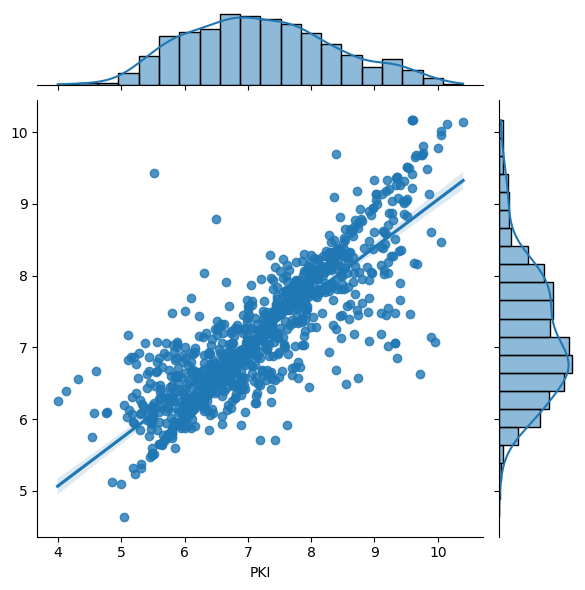

In [ ]:
sns.jointplot(x=y_test, y=y_pred_xgb, kind="reg")

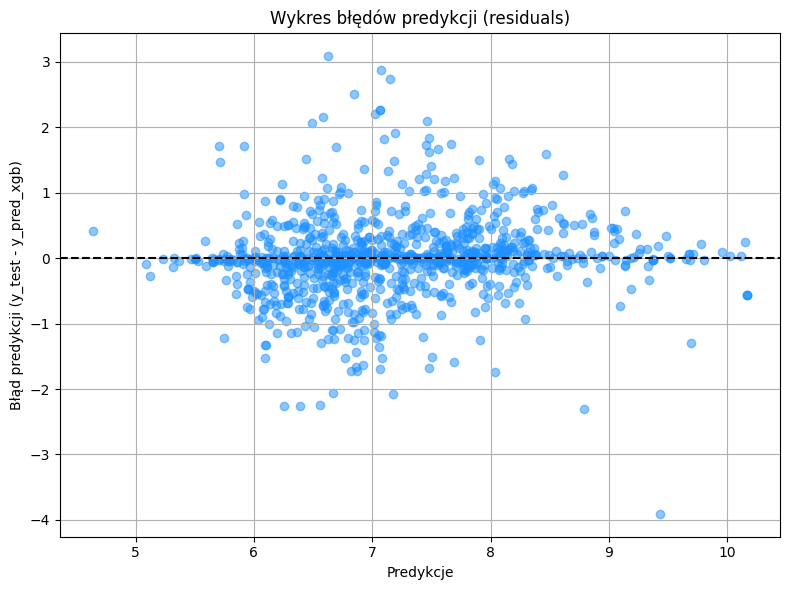

In [ ]:
residuals = y_test - y_pred_xgb

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_xgb, residuals, alpha=0.5, color='dodgerblue')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predykcje')
plt.ylabel('Błąd predykcji (y_test - y_pred_xgb)')
plt.title('Wykres błędów predykcji (residuals)')
plt.grid(True)
plt.tight_layout()
plt.show()

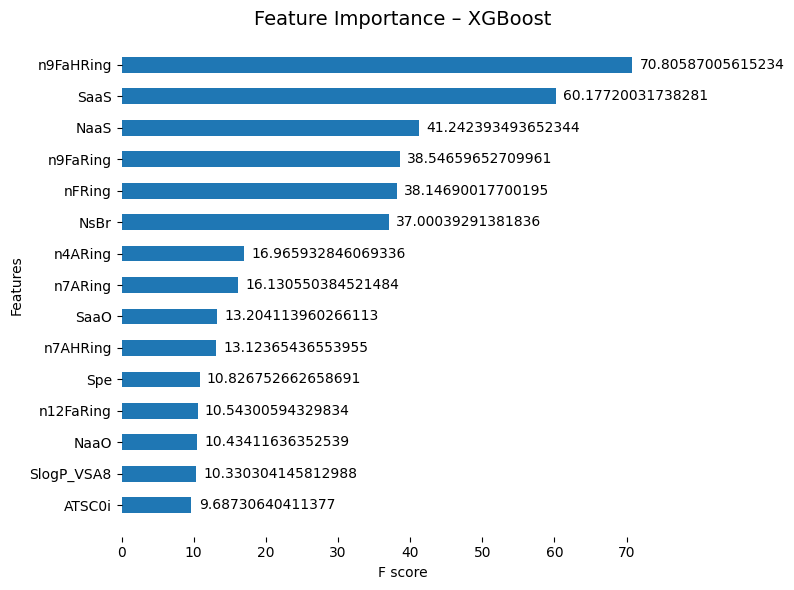

In [ ]:
import xgboost as xgb

fig, ax = plt.subplots(figsize=(8, 6))
xgb.plot_importance(xgb_regr, importance_type='gain', max_num_features=15, height=0.5, ax=ax)
ax.grid(False)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title("Feature Importance – XGBoost", fontsize=14)
plt.tight_layout()
plt.show()

100%|===================| 498/500 [03:14<00:00]       

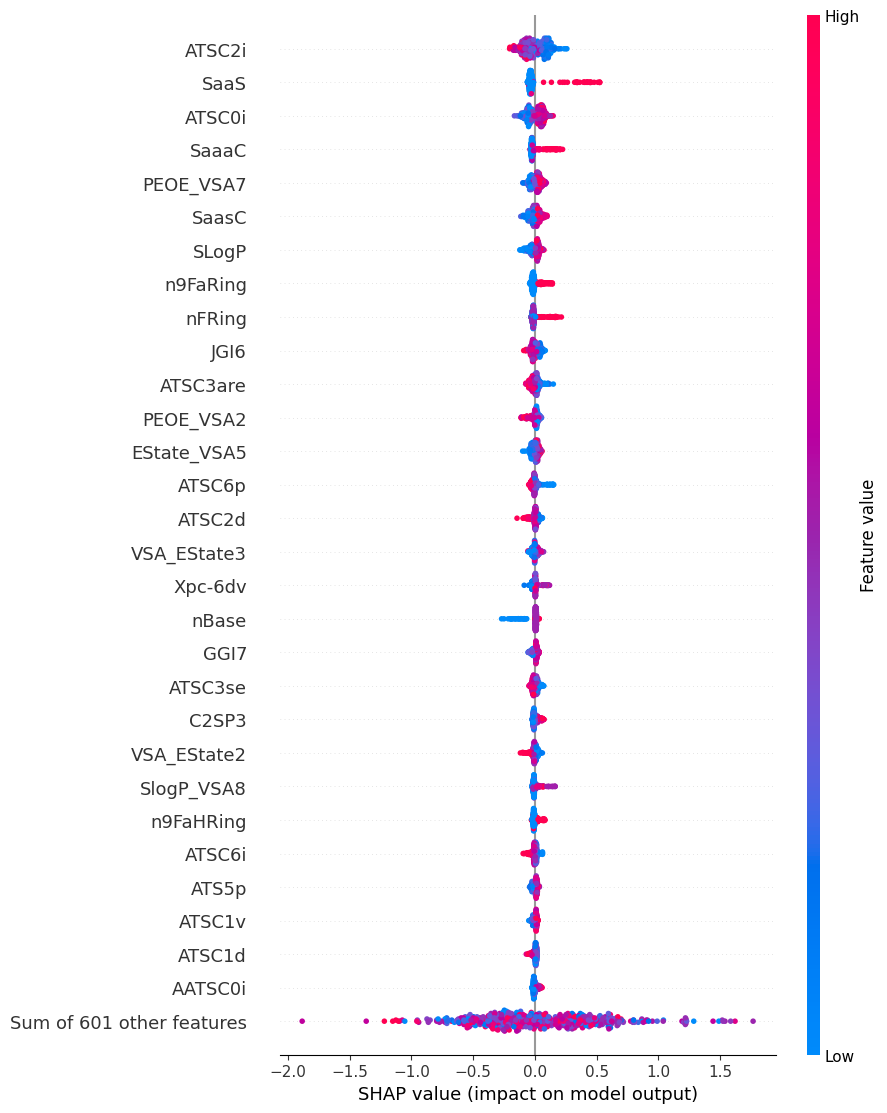

In [ ]:
import shap

# explainer = shap.Explainer(xgb_regr, X_test_transformed)
# shap_values = explainer(X_test[:100])

# shap.plots.beeswarm(shap_values)

sample_idx = np.random.choice(X_test_transformed.shape[0], size=500, replace=False)
X_sample = X_test_transformed.iloc[sample_idx]

explainer = shap.Explainer(xgb_regr, X_sample)
shap_values = explainer(X_sample)

# beeswarm z 30 najważniejszymi cechami
shap.plots.beeswarm(shap_values, max_display=30)

In [ ]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False)

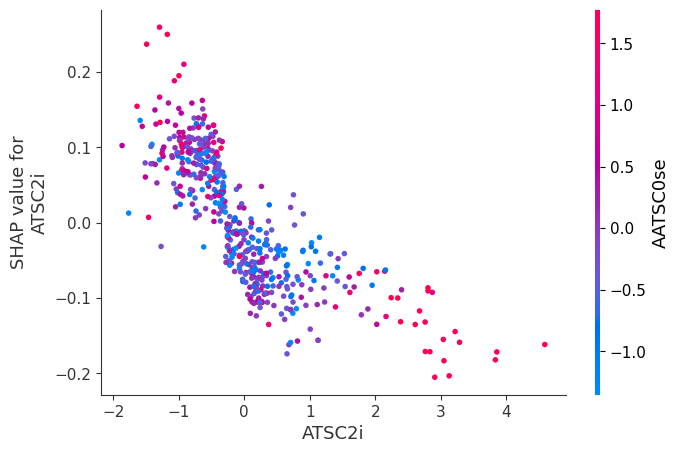

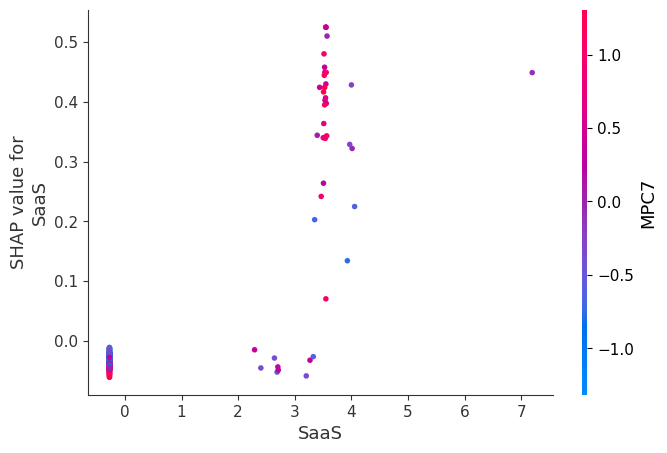

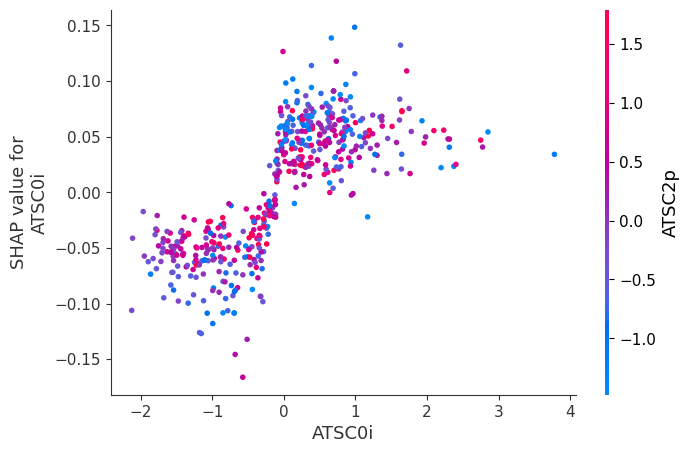

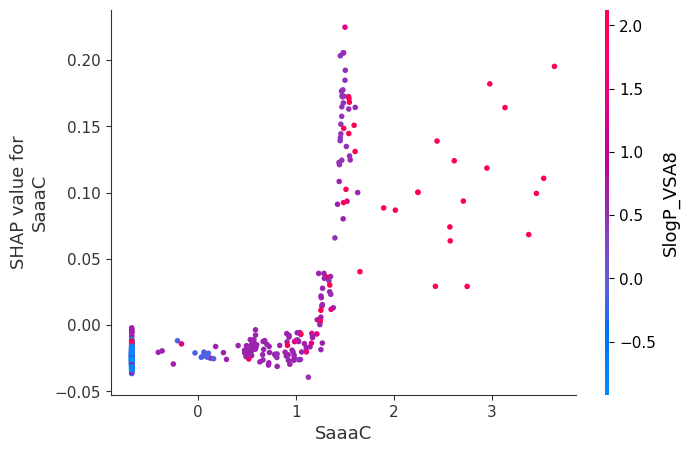

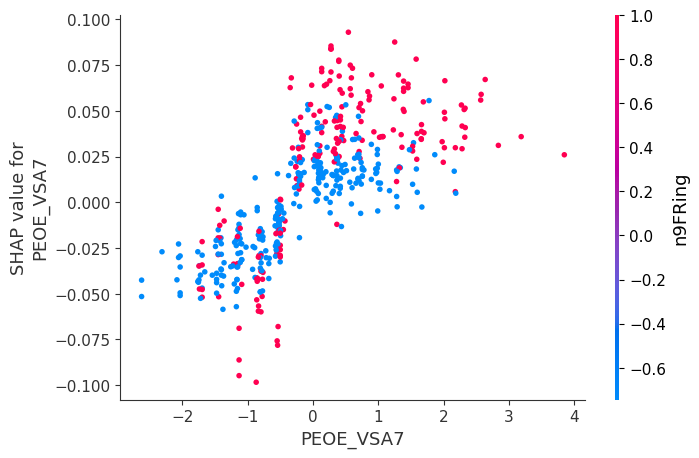

In [ ]:
top_features = importance_df.head(5)['feature'].values

for feat in top_features:
    shap.dependence_plot(feat, shap_values.values, X_sample)

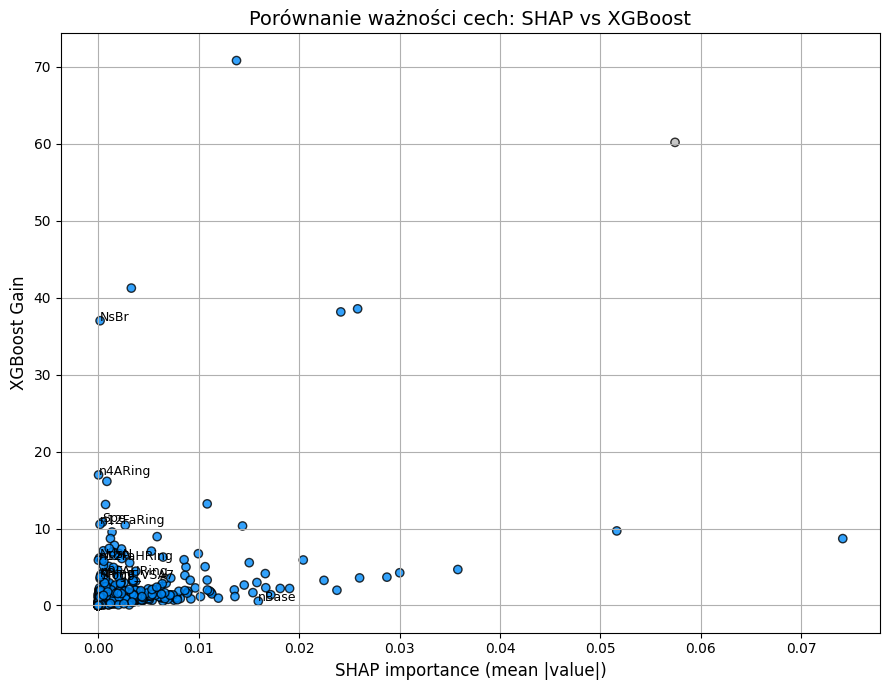

In [ ]:
# ma wysoki gain, ale niski SHAP → jest często używana, ale nie ma dużego wpływu na wynik,

# ma niski gain, ale wysoki SHAP → działa tylko lokalnie lub silnie w interakcjach.

shap_df = pd.DataFrame({
    'feature': X.columns,
    'shap_importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values('shap_importance', ascending=False)


booster = xgb_regr.get_booster()
gain_df = pd.DataFrame(
    booster.get_score(importance_type='gain').items(),
    columns=['feature', 'xgb_gain']
).sort_values('xgb_gain', ascending=False)

comparison_df = pd.merge(shap_df, gain_df, on='feature', how='outer').fillna(0)

comparison_df['shap_rank'] = comparison_df['shap_importance'].rank(ascending=False)
comparison_df['gain_rank'] = comparison_df['xgb_gain'].rank(ascending=False)
comparison_df['rank_diff'] = comparison_df['shap_rank'] - comparison_df['gain_rank']
comparison_df['abs_diff'] = comparison_df['rank_diff'].abs()

cmap = shap.plots.colors.red_blue
colors = comparison_df['rank_diff'].apply(
    lambda x: cmap(1 if x > 0 else 0) if x != 0 else '#BBBBBB'
)


plt.figure(figsize=(9,7))
plt.scatter(
    comparison_df['shap_importance'],
    comparison_df['xgb_gain'],
    c=colors,
    alpha=0.8,
    edgecolors='k'
)

plt.xlabel('SHAP importance (mean |value|)', fontsize=12)
plt.ylabel('XGBoost Gain', fontsize=12)
plt.title('Porównanie ważności cech: SHAP vs XGBoost', fontsize=14)
plt.grid(True)


for _, row in comparison_df.sort_values('abs_diff', ascending=False).head(10).iterrows():
    plt.text(row['shap_importance'], row['xgb_gain'], row['feature'], fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Największe różnice rankingów
comparison_df['abs_diff'] = comparison_df['rank_diff'].abs()
largest_discrepancy = comparison_df.sort_values('abs_diff', ascending=False).head(30)
print(largest_discrepancy[['feature', 'shap_rank', 'gain_rank', 'rank_diff']])

        feature  shap_rank  gain_rank  rank_diff
521     n4ARing     554.00       7.00     547.00
516  n12FaHRing     559.00      36.00     523.00
312        NsBr     512.00       6.00     506.00
517   n12FaRing     516.00      12.00     504.00
308        NdsN     530.00      31.00     499.00
572       nBase      18.00     485.00    -467.00
404         Spe     467.00      11.00     456.00
613       nRing     509.00      56.00     453.00
400  SlogP_VSA7     511.00      61.00     450.00
560   n9FAHRing     497.00      52.00     445.00
530    n5aHRing     475.00      33.00     442.00
495     Zagreb1     527.00      89.00     438.00
318        NsOH     541.00     106.00     435.00
588     nFARing     448.00      23.00     425.00
326      NssssC     537.00     116.00     421.00
81        ATS6Z      65.00     483.00    -418.00
569   nAromAtom     158.00     569.00    -411.00
387        SdsN     458.00      48.00     410.00
506  n10FaHRing     446.00      40.00     406.00
515    n12FRing     

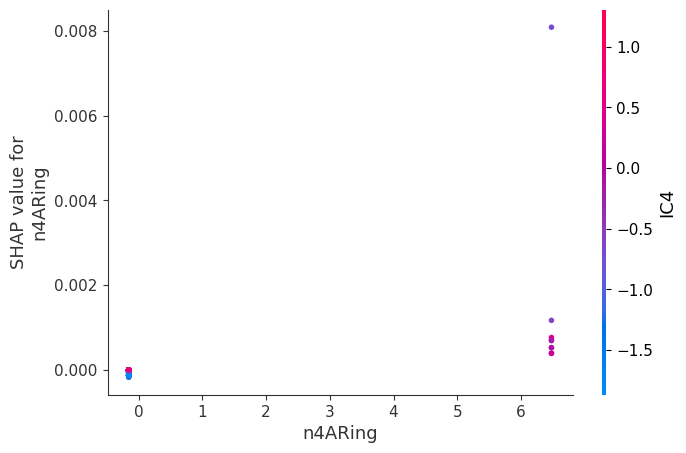

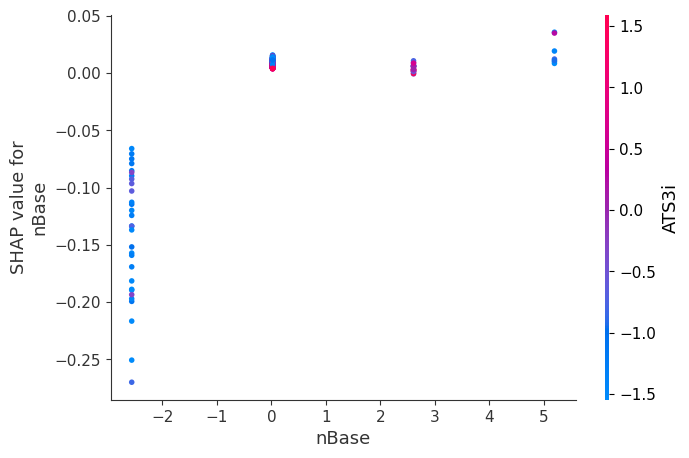

In [ ]:
features_tbc = ['n4ARing', 'nBase']

for feat in features_tbc:
    shap.dependence_plot(feat, shap_values.values, X_sample)

## REGRESJA - Final check na danych testowych

In [ ]:
test = pd.read_csv('test_data_no_pKi.csv')

# wczytanie deskryptorow dla smiles w zbiorze testowym
test_input = pd.merge(test, deskryptory, on='smiles', how='left')

# pozostawienie tylko deskryptorow uzytych w modelu
test_input_final = test_input[[col for col in num_cols if col in test_input.columns]]

# transformacja (standaryzacja)
test_input_final_transformed = pd.DataFrame(
    preprocessor.transform(test_input_final),
    columns=test_input_final.columns,
    index=test_input_final.index
)

In [ ]:
#loaded_model = joblib.load("xgboost_reg.pkl")
# predykcja na zbiorze
final_y_pred = xgb_regr.predict(test_input_final_transformed)

In [ ]:
results = pd.DataFrame({'ID': test['ID'], 'pKi': final_y_pred})
results.to_csv('results.csv', index=False)

## KLASYFIKACJA

### Przygotowanie etykiet

In [ ]:
data = raw_data_num.copy()

In [ ]:
data['reaction'] = data['PKI'].apply(lambda x: 1 if x > 7 else 0)

In [ ]:
profile_data(data)

📊 Profil danych:
➡️ Liczba wierszy: 4887
➡️ Liczba zmiennych: 633
🔢 Liczba zmiennych numerycznych: 632
🔤 Liczba zmiennych tekstowych: 1
🔢 Zmienne numeryczne (632): ['PKI', 'nAcid', 'nBase', 'nAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom', 'nSpiro', 'nBridgehead', 'nHetero', 'nH', 'nC', 'nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'nX', 'ATS0dv', 'ATS1dv', 'ATS2dv', 'ATS3dv', 'ATS4dv', 'ATS5dv', 'ATS6dv', 'ATS7dv', 'ATS8dv', 'ATS0d', 'ATS1d', 'ATS2d', 'ATS3d', 'ATS4d', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS8d', 'ATS0Z', 'ATS1Z', 'ATS2Z', 'ATS3Z', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS7Z', 'ATS8Z', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0se', 'ATS1se', 'ATS2se', 'ATS3se', 'ATS4se', 'ATS5se', 'ATS6se', 'ATS7se', 'ATS8se', 'ATS0pe', 'ATS1pe', 'ATS2pe', 'ATS3pe', 'ATS4pe', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS8pe', 'ATS0are', 'ATS1are', 'ATS2are', 'ATS3are', 'ATS4are', 'ATS5are

,dtype,missing_count,missing_percent,n_unique,top_value,top_freq,mean,min,max,25%,50%,75%,std
PKI,float64,0,0.00,1731,6.00,46,7.18,1.00,11.00,6.32,7.10,7.94,1.15
nAcid,int64,0,0.00,3,0.00,4743,0.03,0.00,2.00,0.00,0.00,0.00,0.18
nBase,int64,0,0.00,6,1.00,4354,0.99,0.00,5.00,1.00,1.00,1.00,0.39
nAromAtom,int64,0,0.00,24,12.00,1386,12.82,0.00,30.00,9.00,12.00,16.00,4.42
nAromBond,int64,0,0.00,22,12.00,1370,13.24,0.00,30.00,10.00,12.00,17.00,4.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zagreb1,float64,0,0.00,105,166.00,170,147.27,38.00,362.00,122.00,154.00,174.00,36.55
Zagreb2,float64,0,0.00,217,192.00,101,174.38,40.00,445.00,145.00,182.00,205.00,43.97
mZagreb2,float64,0,0.00,971,4.89,47,6.03,2.21,15.78,4.97,6.26,7.06,1.45
reaction,int64,0,0.00,2,1.00,2585,0.53,0.00,1.00,0.00,1.00,1.00,0.50


### Przygotowanie danych do modelu

In [ ]:
# przygotowanie danych do modelu

y_class = data['reaction']
X_class = data.drop(columns=['PKI', 'smiles', 'reaction'])

# Podział
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
        X_class,
        y_class,
        test_size=0.2,
        random_state=42,
        stratify=y_class)


# Pipeline dla danych numerycznych
preprocessor_class = StandardScaler()

X_train_transformed_class = pd.DataFrame(
    preprocessor_class.fit_transform(X_train_class),
    columns=X_train_class.columns,
    index=X_train_class.index
)

X_test_transformed_class = pd.DataFrame(
    preprocessor_class.transform(X_test_class),
    columns=X_test_class.columns,
    index=X_test_class.index
)

In [ ]:
# zapis do pliku
joblib.dump(preprocessor_class, "preprocessor_scaler_class.pkl")

['preprocessor_scaler_class.pkl']

### Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [ ]:
def print_clf_feature_importance(model, X, name):
  # Wartości ważności
  importances = model.feature_importances_
  features = X.columns if hasattr(X, 'columns') else [f'feature_{i}' for i in range(len(importances))]

  # DataFrame z ważnością
  importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
  }).sort_values(by='importance', ascending=False)
  # 🔥 Top 15
  top_features = importance_df.head(15)
  # Wykres
  plt.figure(figsize=(10, 6))
  plt.barh(top_features['feature'], top_features['importance'])
  plt.title(f"Feature importance {name}")
  plt.xlabel("Importance")
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()

In [ ]:
def print_confusion_matrix(model, X, y_test, name):

  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  # predykcje
  y_pred_class = model.predict(X)

  # Macierz
  cm = confusion_matrix(y_test, y_pred_class)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap="Blues")
  plt.title(f"Confusion Matrix {name}")
  plt.show()

In [ ]:
def print_classification_report(model, X, y_test, name):
    from sklearn.metrics import classification_report
    import pandas as pd
    import matplotlib.pyplot as plt

    y_pred = model.predict(X)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(classification_report(y_test, y_pred))
    """
    report_df = pd.DataFrame(report).transpose()

    # Filtrujemy klasy (0, 1, ...) i ich metryki
    class_metrics = report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

    # Rysujemy
    class_metrics.plot(kind='bar', figsize=(8, 5))
    plt.title(f"Precision, Recall, F1-score by class – {name}")
    plt.ylabel("Score")
    plt.ylim(0, 1.1)
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    """

In [ ]:
def print_roc_auc(model, X, y_test, name):
  from sklearn.metrics import roc_curve, auc
  plt.figure(figsize=(8,6))
  y_prob = model.predict_proba(X)[:,1]
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

  plt.plot([0,1], [0,1], 'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
# GXBOOST
xgb_clf = XGBClassifier(
    objective='binary:logistic',   # dla klasyfikacji binarnej
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42
)

xgb_clf.fit(X_train_class, y_train_class)
y_pred_class = xgb_clf.predict(X_test_class)

In [ ]:
joblib.dump(xgb_clf, "xgboost_classifier.pkl")

['xgboost_classifier.pkl']

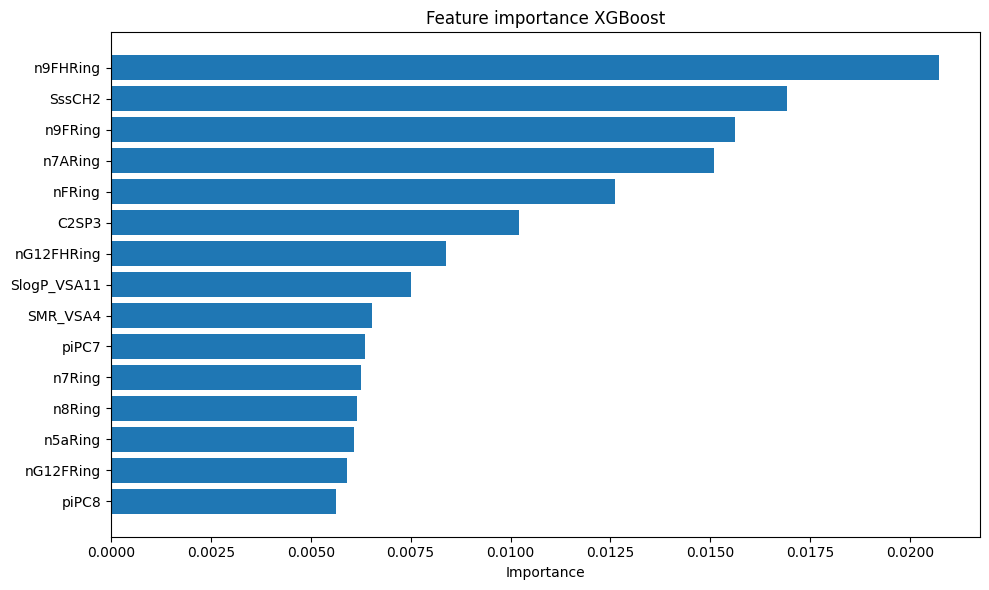

In [ ]:
print_clf_feature_importance(xgb_clf, X_train_class, "XGBoost")

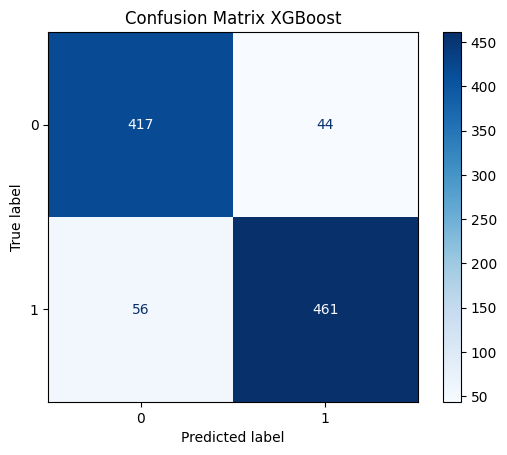

In [ ]:
print_confusion_matrix(xgb_clf, X_test_class, y_test_class, "XGBoost")

In [ ]:
print_classification_report(xgb_clf, X_test_class, y_test_class, "XGBoost")

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       461
           1       0.91      0.89      0.90       517

    accuracy                           0.90       978
   macro avg       0.90      0.90      0.90       978
weighted avg       0.90      0.90      0.90       978



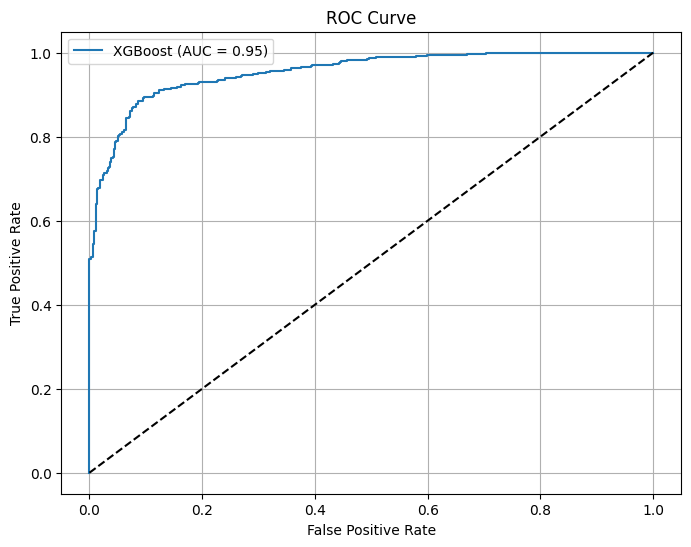

In [ ]:
print_roc_auc(xgb_clf, X_test_class, y_test_class, "XGBoost")

In [ ]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=100,     # liczba drzew
    max_depth=None,       # głębokość drzewa (None = bez limitu)
    random_state=42,      # dla powtarzalności wyników
    n_jobs=-1             # użyj wszystkich rdzeni CPU
)

rf_clf.fit(X_train_class, y_train_class)
y_pred_class_rf = rf_clf.predict(X_test_class)

In [ ]:
joblib.dump(rf_clf, "rf_classifier.pkl")

['rf_classifier.pkl']

In [ ]:
print_classification_report(rf_clf, X_test_class, y_test_class, "Random Forest")

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       461
           1       0.91      0.87      0.89       517

    accuracy                           0.89       978
   macro avg       0.89      0.89      0.89       978
weighted avg       0.89      0.89      0.89       978



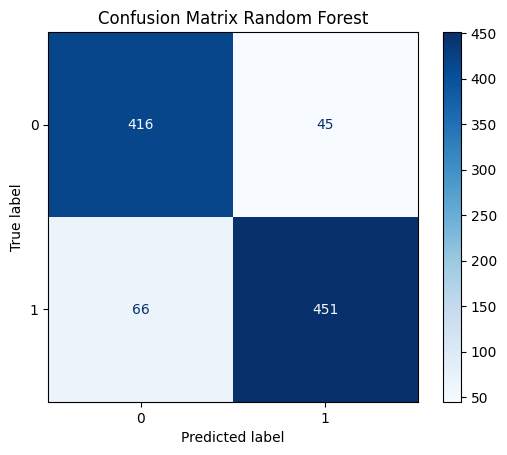

In [ ]:
print_confusion_matrix(rf_clf, X_test_class, y_test_class, "Random Forest")

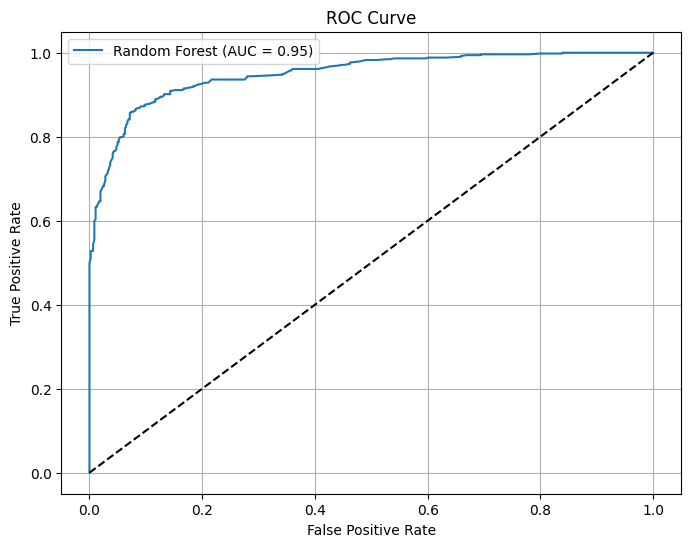

In [ ]:
print_roc_auc(rf_clf, X_test_class, y_test_class, "Random Forest")

### Analiza klasyfikatorow

In [ ]:
def compute_shap_values(model, X_test):
  sample_idx = np.random.choice(X_test.shape[0], size=500, replace=False)
  X_sample = X_test.iloc[sample_idx]

  explainer = shap.Explainer(model, X_sample)
  shap_values = explainer(X_sample)

  return shap_values, X_sample

In [ ]:
def plot_main_shap(shap_values, X_sample):
  if shap_values.values.ndim == 3:
    shap_values = shap_values[..., 1]  # bierzemy wartości dla klasy 1
  # beeswarm z 30 najważniejszymi cechami
  print("SHAP values dla 30  najwazniejszych cech")
  shap.plots.beeswarm(shap_values, max_display=30)

def print_top_shap(shap_values, X_sample):
  if shap_values.values.ndim == 3:
    shap_values = shap_values[..., 1]
  mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
  importance_df = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': mean_abs_shap
  }).sort_values(by='mean_abs_shap', ascending=False)

  top_features = importance_df.head(5)['feature'].values
  for feat in top_features:
    shap.dependence_plot(feat, shap_values.values, X_sample)

def print_comparison_shap_feat_importance(shap_values, X_sample, model):
  # ma wysoki gain, ale niski SHAP → jest często używana, ale nie ma dużego wpływu na wynik,
  # ma niski gain, ale wysoki SHAP → działa tylko lokalnie lub silnie w interakcjach.

  shap_df = pd.DataFrame({
      'feature': X.columns,
      'shap_importance': np.abs(shap_values.values).mean(axis=0)
  }).sort_values('shap_importance', ascending=False)


  booster = model.get_booster()
  gain_df = pd.DataFrame(
      booster.get_score(importance_type='gain').items(),
      columns=['feature', 'xgb_gain']
  ).sort_values('xgb_gain', ascending=False)

  comparison_df = pd.merge(shap_df, gain_df, on='feature', how='outer').fillna(0)
  comparison_df['shap_rank'] = comparison_df['shap_importance'].rank(ascending=False)
  comparison_df['gain_rank'] = comparison_df['xgb_gain'].rank(ascending=False)
  comparison_df['rank_diff'] = comparison_df['shap_rank'] - comparison_df['gain_rank']
  comparison_df['abs_diff'] = comparison_df['rank_diff'].abs()

  cmap = shap.plots.colors.red_blue
  colors = comparison_df['rank_diff'].apply(
      lambda x: cmap(1 if x > 0 else 0) if x != 0 else '#BBBBBB'
  )


  plt.figure(figsize=(9,7))
  plt.scatter(
      comparison_df['shap_importance'],
      comparison_df['xgb_gain'],
      c=colors,
      alpha=0.8,
      edgecolors='k'
  )

  plt.xlabel('SHAP importance (mean |value|)', fontsize=12)
  plt.ylabel('XGBoost Gain', fontsize=12)
  plt.title('Porównanie ważności cech: SHAP vs XGBoost', fontsize=14)
  plt.grid(True)


  for _, row in comparison_df.sort_values('abs_diff', ascending=False).head(10).iterrows():
    plt.text(row['shap_importance'], row['xgb_gain'], row['feature'], fontsize=9)

  plt.tight_layout()
  plt.show()


  # Największe różnice rankingów
  comparison_df['abs_diff'] = comparison_df['rank_diff'].abs()
  largest_discrepancy = comparison_df.sort_values('abs_diff', ascending=False).head(30)
  print(largest_discrepancy[['feature', 'shap_rank', 'gain_rank', 'rank_diff']])

In [ ]:
shap_xgb, sample_xgb = compute_shap_values(xgb_clf, X_test_class)

 99%|===================| 495/500 [01:56<00:01]       

In [ ]:
shap_rf, sample_rf = compute_shap_values(rf_clf, X_test_class)

 98%|===================| 977/1000 [00:39<00:00]       

SHAP values dla 30  najwazniejszych cech


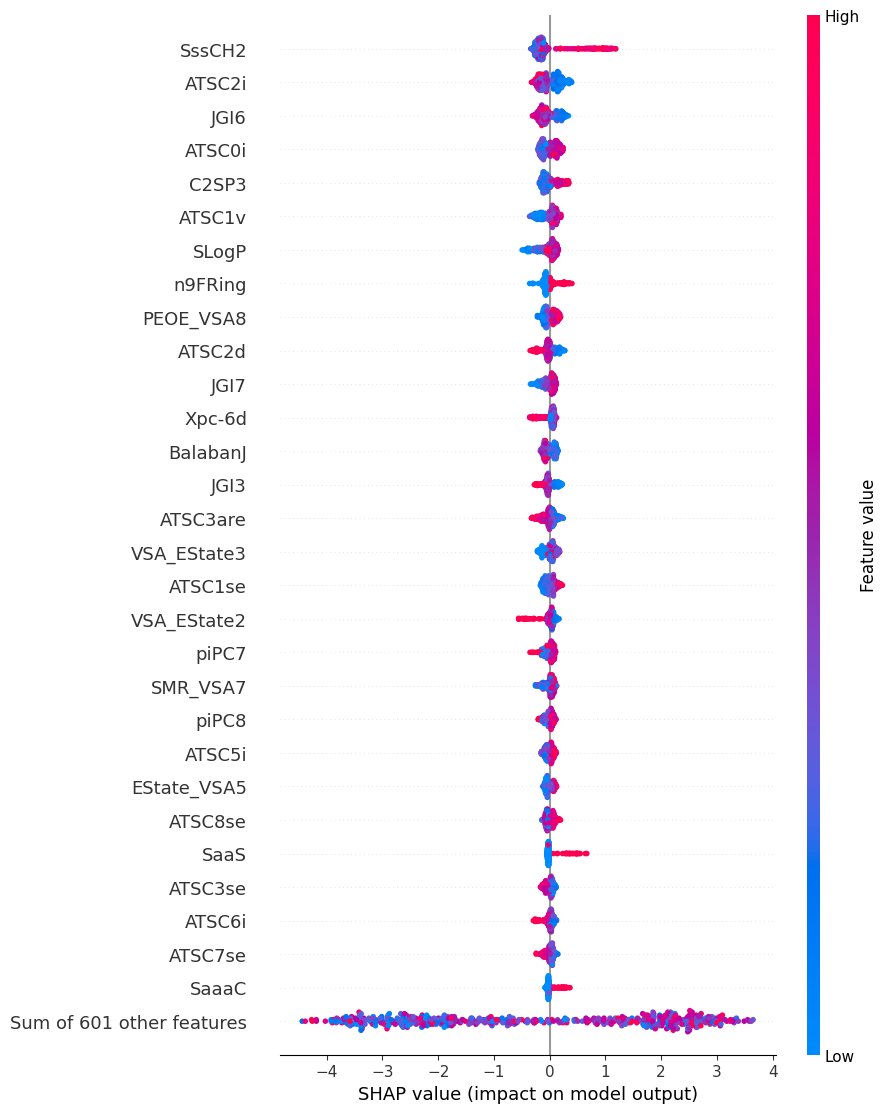

In [ ]:
plot_main_shap(shap_xgb, sample_xgb)

SHAP values dla 30  najwazniejszych cech


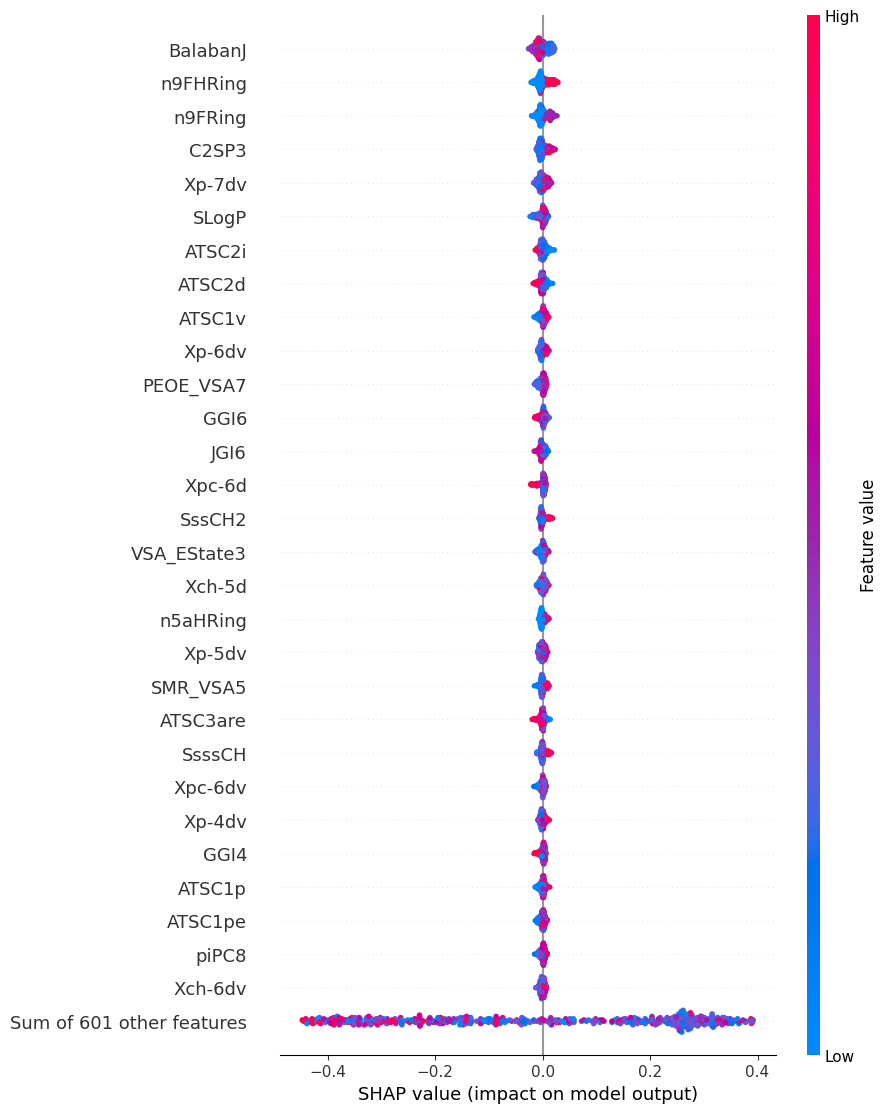

In [ ]:
plot_main_shap(shap_rf, sample_rf)

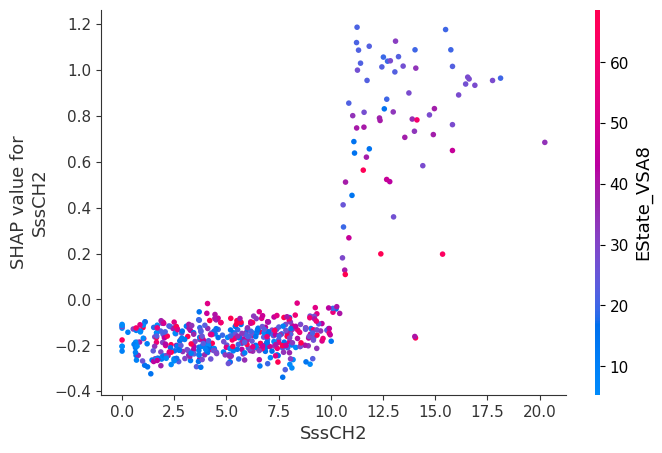

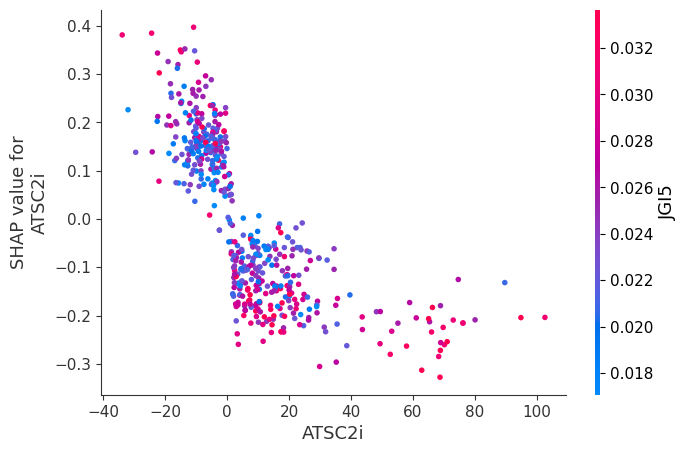

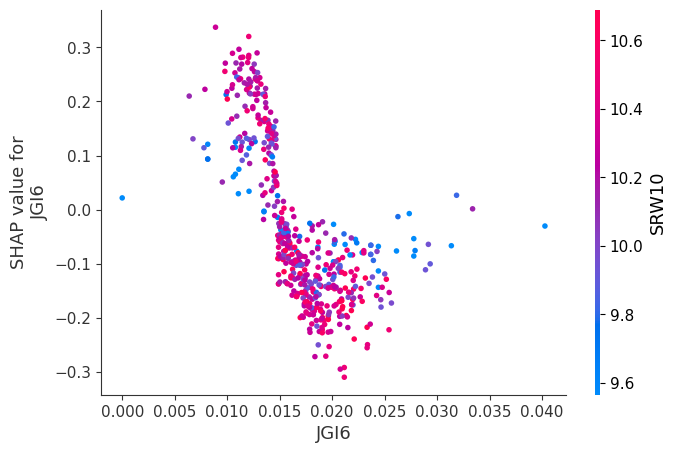

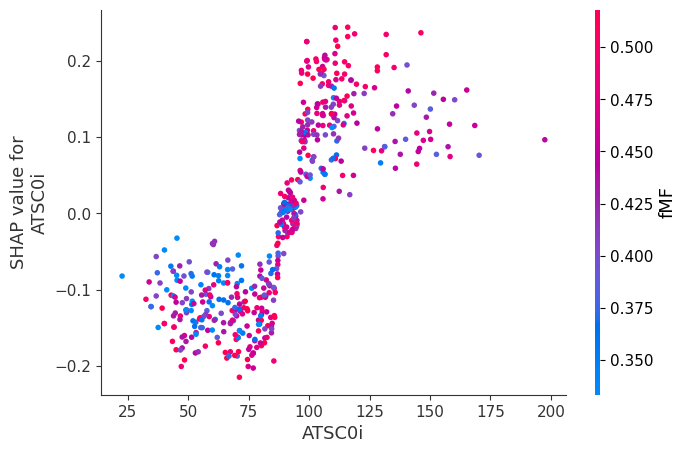

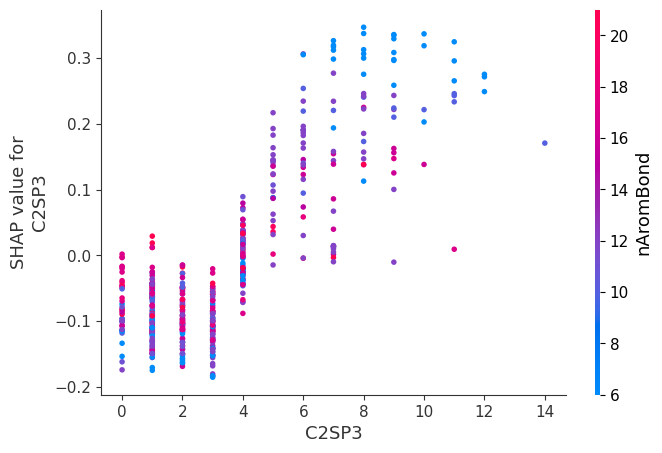

In [ ]:
print_top_shap(shap_xgb, sample_xgb)

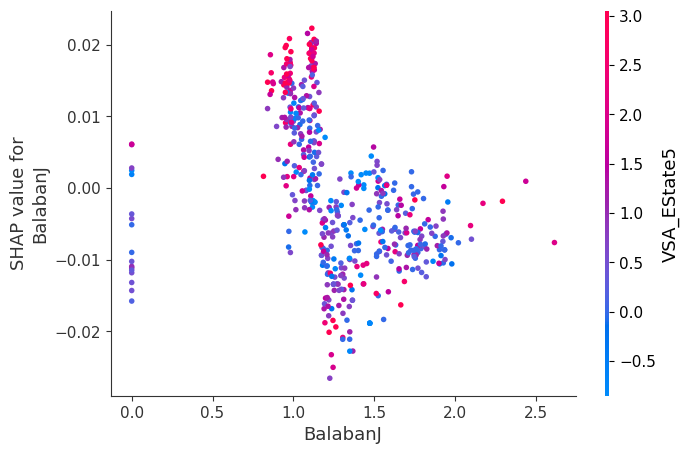

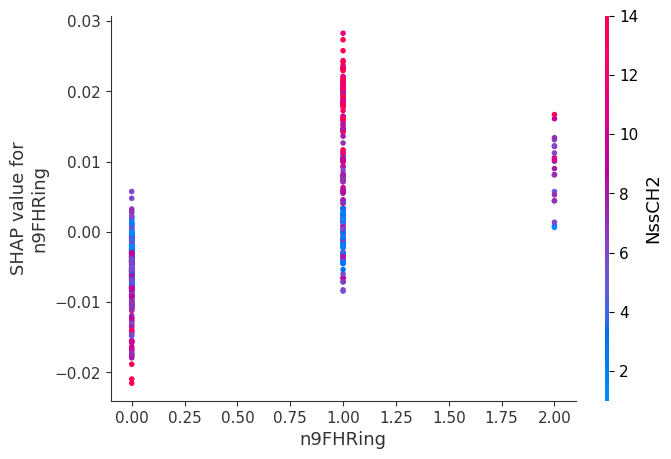

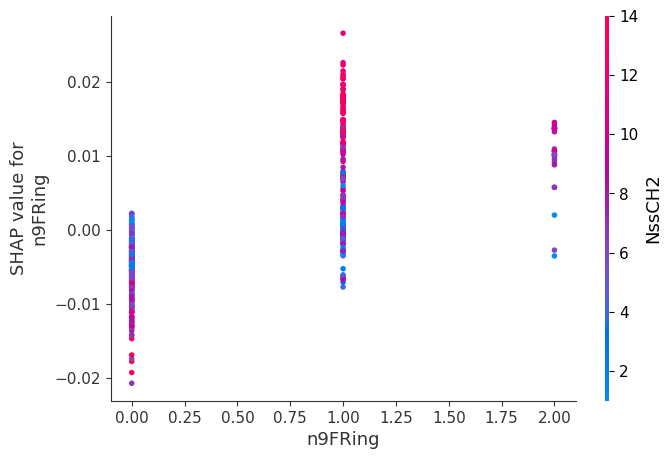

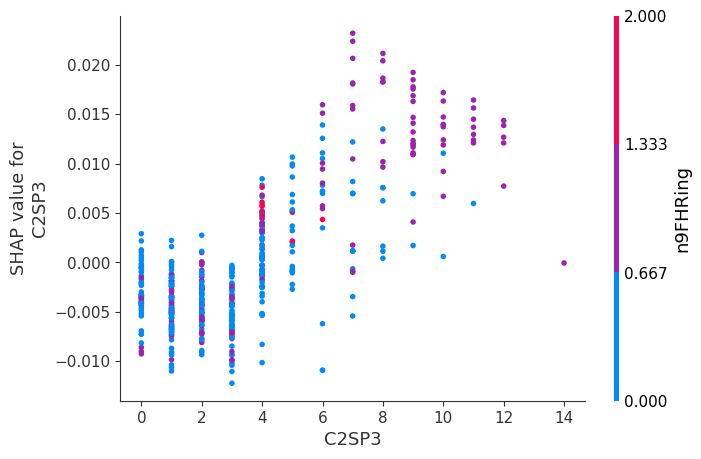

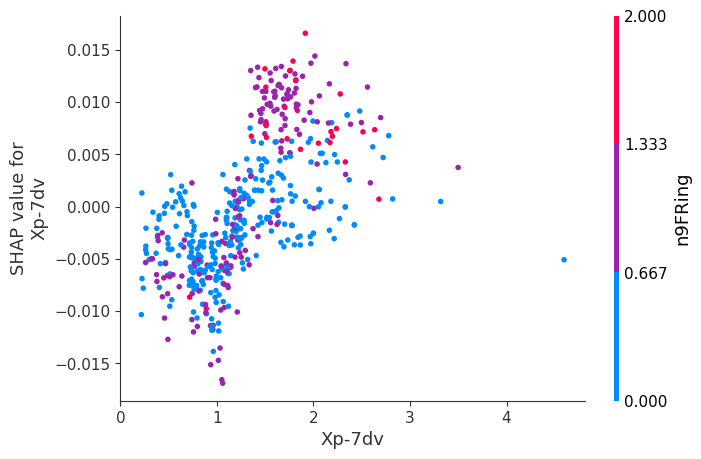

In [ ]:
print_top_shap(shap_rf, sample_rf)

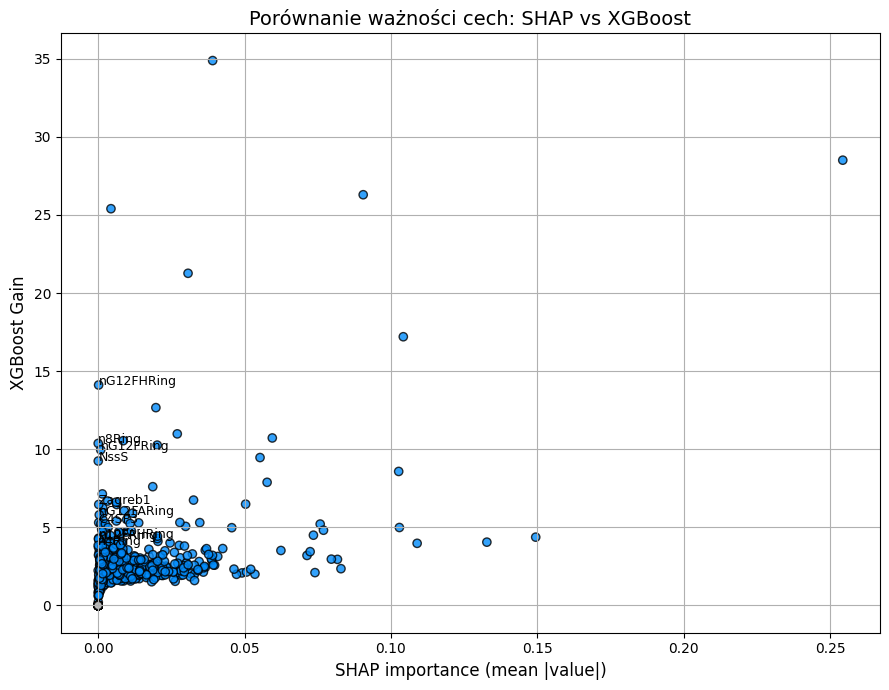

        feature  shap_rank  gain_rank  rank_diff
559      n8Ring     554.00      12.00     542.00
322        NssS     552.00      16.00     536.00
597  nG12FHRing     538.00       7.00     531.00
495     Zagreb1     531.00      25.00     506.00
211       C4SP3     533.00      36.00     497.00
596  nG12FARing     519.00      31.00     488.00
515    n12FRing     544.00      64.00     480.00
523      n4Ring     555.00      80.00     475.00
598   nG12FRing     482.00      14.00     468.00
502  n10FAHRing     528.00      61.00     467.00
507   n10FaRing     525.00      65.00     460.00
510   n11FHRing     540.00      83.00     457.00
195      ATSC8i      49.00     505.00    -456.00
453       Xc-4d     506.00      67.00     439.00
162    ATSC5are      77.00     513.00    -436.00
412         Sse     474.00      40.00     434.00
560   n9FAHRing     445.00      20.00     425.00
318        NsOH     466.00      43.00     423.00
511    n11FRing     542.00     120.00     422.00
450        WPol     

In [ ]:
print_comparison_shap_feat_importance(shap_xgb, sample_xgb, xgb_clf)

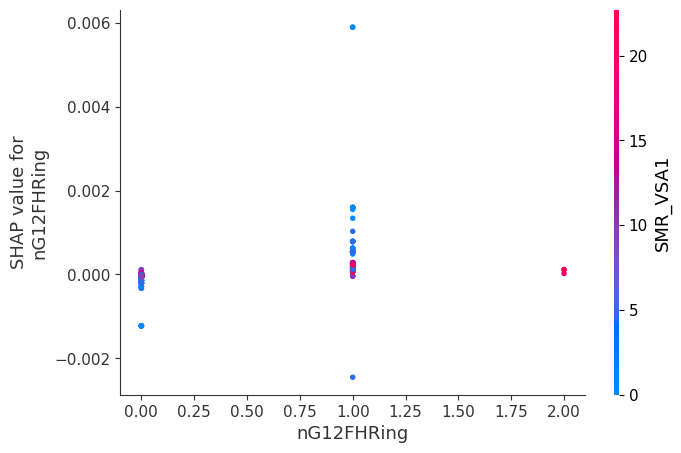

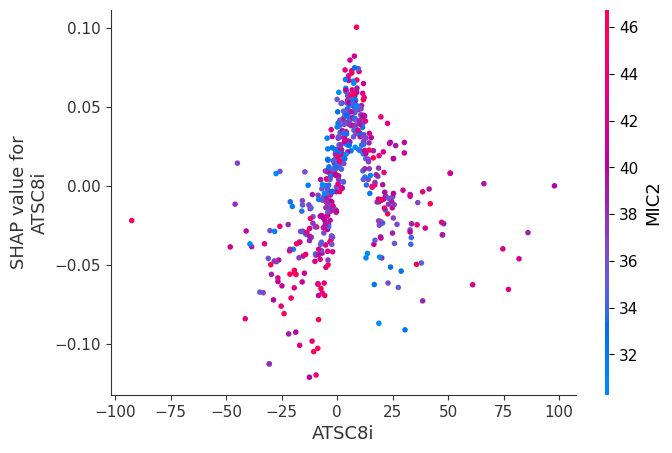

In [ ]:
features_tbc = ['nG12FHRing', 'ATSC8i']

for feat in features_tbc:
    shap.dependence_plot(feat, shap_xgb.values, sample_xgb)

# <b>Archiwum</b>

🌍 **Lokalizacja:** D17 1.20

👩‍💻 **Informacje o hackathonie:**
- Nasi współpracownicy z Wydziału Farmaceutycznego UJ mają przygotowany bardzo ciekawy zbiór danych opisujący aktywację receptorów w reakcji na różne cząsteczki.
- **Państwa zadaniem będzie podjęcie się predykcji tego, czy cząstka aktywuje receptor w oparciu o jej własności chemiczne.**
- Całość ma formę konkursu zakończonego  prezentacją wyników osiągniętych przez kilkuosobowe grupy.
- W ramach hackatonu staną Państwo przed zadaniem **wytrenowania modelu klasyfikacji bądź regresji** na zbiorze danych medycznych.
- Nie narzucamy narzędzi, z których pomocą zadanie to ma zostać wykonane. Przykładowo mogą Państwo w ramach grupy ustalić, że korzystacie z pythona, dane obrabiacie za pomocą bilioteki pandas i numpy, modele trenujecie w oparciu o scikit-learn, xgboost, pytorch etc, a raport/wizualizacje przygotowujecie w plotly.
- Do ustrukturyzowania współpracy w grupie przyda się znajomość systemu kontroli wersji git albo korzystanie z google collab.

**Przykładowe datasety:**
- https://www.kaggle.com/datasets?search=solubility
- `from sklearn.datasets import make_classification`, następnie `X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)`

**Link do draftu prezentacji:**
- https://docs.google.com/presentation/d/1jt7GbmdeuZoEze4hqkJGgNT4b8tSPsd_/edit?usp=sharing&ouid=115449660162134839913&rtpof=true&sd=true
- `do dostosowania wedle naszych potrzeb w niedzielę ;)`

## 🎯 Wczytanie, EDA, przygotowanie danych (Sylwia)

In [ ]:
# niewykorzystane wizualizacje
def plot_categorical_bars(df, top_n=10):
    print("Top 10 zmiennych nienumerycznych.")
    cat_cols = df.select_dtypes(include=["object", "category", "string", "bool"]).columns

    if len(cat_cols) == 0:
        print("Brak zmiennych nienumerycznych.")
        return

    n = len(cat_cols)
    ncols = 2
    nrows = math.ceil(n / 2)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        vc = df[col].value_counts().head(top_n)
        sns.barplot(x=vc.values, y=vc.index, ax=axes[i])
        axes[i].set_title(f"Top {top_n}: {col}")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])  # usuń puste osie

    plt.tight_layout()
    plt.show()

def plot_scatter(df, x_col, y_col, hue=None, figsize=(8, 6), alpha=0.7):
    if x_col not in df.columns or y_col not in df.columns:
        raise ValueError("Podane kolumny muszą istnieć w DataFrame.")

    if not pd.api.types.is_numeric_dtype(df[x_col]) or not pd.api.types.is_numeric_dtype(df[y_col]):
        raise TypeError("Zarówno x_col jak i y_col muszą być typu numerycznego.")

    plt.figure(figsize=figsize)
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue, alpha=alpha)
    plt.title(f"Scatter plot: {y_col} vs {x_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

def plot_numeric_by_category(df, numeric_col, category_col, plot_type="box", figsize=(10, 6), rotate_x=True):
    if numeric_col not in df.columns or category_col not in df.columns:
        raise ValueError("Podane kolumny muszą istnieć w DataFrame.")

    if not pd.api.types.is_numeric_dtype(df[numeric_col]):
        raise TypeError(f"Kolumna '{numeric_col}' musi być typu numerycznego.")

    if pd.api.types.is_numeric_dtype(df[category_col]):
        print(f"ℹ️ Ostrzeżenie: '{category_col}' wygląda na numeryczną, ale używana jako kategoryczna.")

    plt.figure(figsize=figsize)

    if plot_type == "box":
        sns.boxplot(data=df, x=category_col, y=numeric_col)
    elif plot_type == "violin":
        sns.violinplot(data=df, x=category_col, y=numeric_col, inner="quartile")
    elif plot_type == "strip":
        sns.stripplot(data=df, x=category_col, y=numeric_col, jitter=True, alpha=0.5)
    else:
        raise ValueError("plot_type musi być jednym z: 'box', 'violin', 'strip'.")

    plt.title(f"{numeric_col} wg kategorii: {category_col}")
    if rotate_x:
        plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def plot_grouped_countplot(
    df,
    category_col,
    hue_col,
    figsize=(10, 6),
    order=None,
    hue_order=None,
    palette="Set2",
    rotate_x=True
):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=category_col, hue=hue_col, order=order, hue_order=hue_order, palette=palette)

    plt.title(f"Liczebność: {category_col} z podziałem na {hue_col}")
    plt.xlabel(category_col)
    plt.ylabel("Liczba obserwacji")

    if rotate_x:
        plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

def plot_stacked_bar(
    df,
    category_col,
    stack_col,
    normalize=False,
    figsize=(10, 6),
    colormap="Set2",
    rotate_x=True
):
    cross = pd.crosstab(df[category_col], df[stack_col])

    if normalize:
        cross = cross.div(cross.sum(axis=1), axis=0)

    cross.plot(kind="bar", stacked=True, figsize=figsize, colormap=colormap)

    plt.title(f"{'Proporcje' if normalize else 'Liczebność'}: {stack_col} w ramach {category_col}")
    plt.xlabel(category_col)
    plt.ylabel("Proporcja" if normalize else "Liczba obserwacji")

    if rotate_x:
        plt.xticks(rotation=45, ha="right")

    plt.legend(title=stack_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
# Macierze korelacji
def plot_correlation_matrix(df, method="pearson", figsize=(10, 8), mask_upper=False, sort_by=None, threshold=None):
    print("Macierz korelacji zmiennych numerycznych")
    num_df = df.select_dtypes(include=["number"])

    if num_df.shape[1] < 2:
        print("Potrzeba co najmniej dwóch zmiennych numerycznych do wyznaczenia korelacji.")
        return

    corr = num_df.corr(method=method)
    # Sortuj według korelacji z wybraną zmienną
    if sort_by is not None and sort_by in corr.columns:
        sorted_cols = corr[sort_by].abs().sort_values(ascending=False).index
        corr = corr.loc[sorted_cols, sorted_cols]

    # Rozmiar figury dynamicznie zależny od liczby zmiennych
    n = len(corr.columns)
    figsize = (0.6 * n, 0.6 * n)

    mask = None
    # maskuje górny trójkąt jesli wymagane
    if mask_upper:
        mask = np.triu(np.ones_like(corr, dtype=bool))

    # Zastosuj threshold: maskuj wartości poniżej progu
    if threshold is not None:
        threshold_mask = corr.abs() < threshold
        if mask is not None:
            mask = np.logical_or(mask, threshold_mask)
        else:
            mask = threshold_mask

    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        mask=mask,
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        square=True,
        cbar_kws={"shrink": 0.75}
    )
    title_extra = f", |corr| > {threshold}" if threshold else ""
    plt.title(f"Macierz korelacji ({method}){title_extra}", fontsize=14)
    plt.tight_layout()
    plt.show()

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1)) if n > 1 else 0
    r_corr = r - ((r-1)**2)/(n-1) if n > 1 else r
    k_corr = k - ((k-1)**2)/(n-1) if n > 1 else k
    denom = min((k_corr - 1), (r_corr - 1))
    return np.sqrt(phi2_corr / denom) if denom > 0 else np.nan

def plot_cramers_v_heatmap(
    df,
    categorical_columns=None,
    annot=True,
    cmap="YlOrBr",
    mask_upper=True,
    base_size=1.2,
    max_figsize=18
):
    # Wybierz kolumny kategoryczne
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    if len(categorical_columns) < 2:
        print("Potrzeba co najmniej dwóch zmiennych kategorycznych.")
        return

    # Oblicz macierz Cramér's V
    n = len(categorical_columns)
    result = pd.DataFrame(np.ones((n, n)), columns=categorical_columns, index=categorical_columns)

    for col1, col2 in combinations(categorical_columns, 2):
        v = cramers_v(df[col1], df[col2])
        result.loc[col1, col2] = v
        result.loc[col2, col1] = v

    # Maska górnego trójkąta
    mask = None
    if mask_upper:
        mask = np.triu(np.ones_like(result, dtype=bool))

    # Dynamiczny rozmiar
    size = min(base_size * n, max_figsize)
    figsize = (size, size)

    # Rysuj heatmapę
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        result,
        annot=annot,
        cmap=cmap,
        vmin=0,
        vmax=1,
        square=True,
        linewidths=0.5,
        mask=mask,
        cbar_kws={"shrink": 0.75}
    )

    # Etykiety
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    plt.title("Cramér's V – korelacje między zmiennymi kategorycznymi", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# Czyszczenie danych

def clean_missing_data(df, col_threshold=0.4, columns="all", verbose=True):
    df = df.copy()

    # Usuń kolumny z nadmiarem braków
    col_nan_ratio = df.isnull().mean()
    cols_to_drop = col_nan_ratio[col_nan_ratio > col_threshold].index.tolist()
    df.drop(columns=cols_to_drop, inplace=True)

    if verbose and cols_to_drop:
        print(f"📉 Usunięto {len(cols_to_drop)} kolumn z brakami > {col_threshold*100:.0f}%: {cols_to_drop}\n")

    n_before = len(df)

    # Usuń wiersze
    if columns == "all":
        df.dropna(inplace=True)
        method_desc = "wszystkich kolumnach"
    elif isinstance(columns, list):
        valid_cols = [col for col in columns if col in df.columns]
        if not valid_cols:
            if verbose:
                print("⚠️ Żadna z podanych kolumn nie występuje w DataFrame — nic nie usunięto.")
            return df
        df.dropna(subset=valid_cols, inplace=True)
        method_desc = f"istniejących kolumnach: {valid_cols}"
    else:
        raise ValueError("Argument 'columns' musi być 'all' lub listą kolumn.")

    n_after = len(df)

    if verbose:
        dropped = n_before - n_after
        print(f"🧹 Usunięto {dropped} wierszy z brakami w {method_desc}")
        print(f"✅ Pozostało {n_after} wierszy i {df.shape[1]} kolumn.")

    return df


def fill_missing_values_by_column(df, value_dict, verbose=True):
    df = df.copy()

    for col, strategy in value_dict.items():
        if col not in df.columns:
            if verbose:
                print(f"⚠️ Kolumna '{col}' nie istnieje w DataFrame — pominięto.")
            continue

        n_missing = df[col].isna().sum()
        if n_missing == 0:
            if verbose:
                print(f"ℹ️ Kolumna '{col}' nie zawiera braków — pominięto.")
            continue

        if strategy == "mean":
            fill_val = df[col].mean()
        elif strategy == "median":
            fill_val = df[col].median()
        elif strategy == "mode":
            mode_series = df[col].mode()
            fill_val = mode_series.iloc[0] if not mode_series.empty else None
        else:
            fill_val = strategy  # stała wartość

        df[col].fillna(fill_val, inplace=True)

        if verbose:
            print(f"✅ Wypełniono {n_missing} braków w kolumnie '{col}' wartością: {fill_val}")

    return df

def drop_duplicates_verbose(df, subset=None, keep="first", verbose=True):
    df = df.copy()
    n_before = len(df)

    df.drop_duplicates(subset=subset, keep=keep, inplace=True)
    n_after = len(df)

    if verbose:
        dropped = n_before - n_after
        subset_info = f"w kolumnach {subset}" if subset else "we wszystkich kolumnach"
        print(f"🧹 Usunięto {dropped} zduplikowanych wierszy ({subset_info}).")
        print(f"✅ Pozostało {n_after} wierszy.")

    return df

def convert_columns_by_type(df, type_to_columns_map, verbose=True, errors="raise"):
    df = df.copy()

    for target_type, cols in type_to_columns_map.items():
        valid_cols = [col for col in cols if col in df.columns]
        invalid_cols = [col for col in cols if col not in df.columns]

        for col in valid_cols:
            try:
                df[col] = df[col].astype(target_type, errors=errors)
                if verbose:
                    print(f"🔁 Kolumna '{col}' przekonwertowana na typ {target_type}")
            except Exception as e:
                if errors == "raise":
                    raise e
                elif verbose:
                    print(f"❌ Błąd przy konwersji '{col}' na {target_type}: {e}")

        if invalid_cols and verbose:
            print(f"⚠️ Pominięto nieistniejące kolumny: {invalid_cols}")

    return df

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [ ]:
# Przygotowanie danych do modelu
# Zamiana na dane numeryczne lub boolowskie (kazdy model)
# Normalizacja
# Podzial na zbior testowy i treningowy (ten sam podzial, ten sam seed)

def prepare_pipeline_split(df, target, test_size=0.2, random_state=42, stratify=True, verbose=True):
    # Rozdzielenie X i y
    y = df[target]
    X = df.drop(columns=target)

    # Podział
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y if stratify and y.nunique() < len(y) else None
    )

    # Identyfikacja kolumn
    numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    # Pipeline dla danych numerycznych
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    # Pipeline dla danych kategorycznych
    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False))
    ])

    # Połączenie w ColumnTransformer
    preprocessor = ColumnTransformer([
        ("num", numeric_pipeline, numeric_cols),
        ("cat", categorical_pipeline, categorical_cols)
    ])

    # Fit tylko na danych treningowych
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    if verbose:
        print(f"🎯 Zmienna celu: {target}")
        print(f"📦 Kolumny numeryczne ({len(numeric_cols)}): {numeric_cols}")
        print(f"📦 Kolumny kategoryczne ({len(categorical_cols)}): {categorical_cols}")
        print(f"🔄 Train shape: {X_train_transformed.shape}, Test shape: {X_test_transformed.shape}")

    return X_train_transformed, X_test_transformed, y_train, y_test, preprocessor

## 📈 Regresja (Przemysław)

In [ ]:
# Metryki SMALL transformed
print_regression_metrics(y_test, y_pred_regr, "LinearRegression")
print_regression_metrics(y_test, y_pred_ridge, "Ridge")
print_regression_metrics(y_test, y_pred_ridgeCV, "RidgeCV")
print_regression_metrics(y_test, y_pred_SGD, "SGDRegressor")
print_regression_metrics(y_test, y_pred_lasso, "Lasso")
print_regression_metrics(y_test, y_pred_lassoCV, "LassoCV")
print_regression_metrics(y_test, y_pred_elastic, "ElasticNet")
print_regression_metrics(y_test, y_pred_elasticCV, "ElasticNetCV")
print_regression_metrics(y_test, y_pred_huber, "HuberRegressor")
print_regression_metrics(y_test, y_pred_xgb, "XGBRegressor")

"""
Metryki dla LinearRegression:
  R2:    0.2956
  RMSE:  0.9762
  MAPE:  0.0932

Metryki dla Ridge:
  R2:    0.4552
  RMSE:  0.8586
  MAPE:  0.0900

Metryki dla RidgeCV:
  R2:    0.4377
  RMSE:  0.8723
  MAPE:  0.0899

Metryki dla SGDRegressor:
  R2:    -2599476720484617216.0000
  RMSE:  1875416308.2780
  MAPE:  185898181.3238

Metryki dla Lasso:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla LassoCV:
  R2:    0.4532
  RMSE:  0.8601
  MAPE:  0.0904

Metryki dla ElasticNet:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla ElasticNetCV:
  R2:    0.4520
  RMSE:  0.8610
  MAPE:  0.0905

Metryki dla HuberRegressor:
  R2:    0.3952
  RMSE:  0.9046
  MAPE:  0.0918

Metryki dla XGBRegressor:
  R2:    0.5598
  RMSE:  0.7718
  MAPE:  0.0839
  """

Metryki dla LinearRegression:
  R2:    0.2956
  RMSE:  0.9762
  MAPE:  0.0932

Metryki dla Ridge:
  R2:    0.4552
  RMSE:  0.8586
  MAPE:  0.0900

Metryki dla RidgeCV:
  R2:    0.4377
  RMSE:  0.8723
  MAPE:  0.0899

Metryki dla SGDRegressor:
  R2:    -2599476720484617216.0000
  RMSE:  1875416308.2780
  MAPE:  185898181.3238

Metryki dla Lasso:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla LassoCV:
  R2:    0.4532
  RMSE:  0.8601
  MAPE:  0.0904

Metryki dla ElasticNet:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla ElasticNetCV:
  R2:    0.4520
  RMSE:  0.8610
  MAPE:  0.0905

Metryki dla HuberRegressor:
  R2:    0.3952
  RMSE:  0.9046
  MAPE:  0.0918

Metryki dla XGBRegressor:
  R2:    0.5598
  RMSE:  0.7718
  MAPE:  0.0839



In [ ]:
# Metryki SMALL

print_regression_metrics(y_test, y_pred_regr, "LinearRegression")
print_regression_metrics(y_test, y_pred_ridge, "Ridge")
print_regression_metrics(y_test, y_pred_ridgeCV, "RidgeCV")
print_regression_metrics(y_test, y_pred_SGD, "SGDRegressor")
print_regression_metrics(y_test, y_pred_lasso, "Lasso")
print_regression_metrics(y_test, y_pred_lassoCV, "LassoCV")
print_regression_metrics(y_test, y_pred_elastic, "ElasticNet")
print_regression_metrics(y_test, y_pred_elasticCV, "ElasticNetCV")
print_regression_metrics(y_test, y_pred_huber, "HuberRegressor")
print_regression_metrics(y_test, y_pred_xgb, "XGBRegressor")

"""
Metryki dla LinearRegression:
  R2:    0.2956
  RMSE:  0.9762
  MAPE:  0.0932

Metryki dla Ridge:
  R2:    0.4295
  RMSE:  0.8786
  MAPE:  0.0890

Metryki dla RidgeCV:
  R2:    -371.1628
  RMSE:  22.4399
  MAPE:  1.1096

Metryki dla SGDRegressor:
  R2:    -118488962374765072816215672806758852263185219584.0000
  RMSE:  400399632456618493345792.0000
  MAPE:  11161195800075811422208.0000

Metryki dla Lasso:
  R2:    0.2068
  RMSE:  1.0359
  MAPE:  0.1150

Metryki dla LassoCV:
  R2:    0.0135
  RMSE:  1.1553
  MAPE:  0.1341

Metryki dla ElasticNet:
  R2:    0.2416
  RMSE:  1.0130
  MAPE:  0.1114

Metryki dla ElasticNetCV:
  R2:    0.0135
  RMSE:  1.1553
  MAPE:  0.1341

Metryki dla HuberRegressor:
  R2:    -0.3524
  RMSE:  1.3527
  MAPE:  0.1456

Metryki dla XGBRegressor:
  R2:    0.5598
  RMSE:  0.7718
  MAPE:  0.0839
  """

Metryki dla LinearRegression:
  R2:    0.2956
  RMSE:  0.9762
  MAPE:  0.0932

Metryki dla Ridge:
  R2:    0.4295
  RMSE:  0.8786
  MAPE:  0.0890

Metryki dla RidgeCV:
  R2:    -371.1628
  RMSE:  22.4399
  MAPE:  1.1096

Metryki dla SGDRegressor:
  R2:    -118488962374765072816215672806758852263185219584.0000
  RMSE:  400399632456618493345792.0000
  MAPE:  11161195800075811422208.0000

Metryki dla Lasso:
  R2:    0.2068
  RMSE:  1.0359
  MAPE:  0.1150

Metryki dla LassoCV:
  R2:    0.0135
  RMSE:  1.1553
  MAPE:  0.1341

Metryki dla ElasticNet:
  R2:    0.2416
  RMSE:  1.0130
  MAPE:  0.1114

Metryki dla ElasticNetCV:
  R2:    0.0135
  RMSE:  1.1553
  MAPE:  0.1341

Metryki dla HuberRegressor:
  R2:    -0.3524
  RMSE:  1.3527
  MAPE:  0.1456

Metryki dla XGBRegressor:
  R2:    0.5598
  RMSE:  0.7718
  MAPE:  0.0839



In [ ]:
# Metryki

print_regression_metrics(y_test, y_pred_regr, "LinearRegression")
print_regression_metrics(y_test, y_pred_ridge, "Ridge")
print_regression_metrics(y_test, y_pred_ridgeCV, "RidgeCV")
print_regression_metrics(y_test, y_pred_SGD, "SGDRegressor")
print_regression_metrics(y_test, y_pred_lasso, "Lasso")
print_regression_metrics(y_test, y_pred_lassoCV, "LassoCV")
print_regression_metrics(y_test, y_pred_elastic, "ElasticNet")
print_regression_metrics(y_test, y_pred_elasticCV, "ElasticNetCV")
print_regression_metrics(y_test, y_pred_huber, "HuberRegressor")
print_regression_metrics(y_test, y_pred_xgb, "XGBRegressor")

"""
Metryki dla LinearRegression:
  R2:    -4025.5590
  RMSE:  73.8111
  MAPE:  0.6941

Metryki dla Ridge:
  R2:    0.4636
  RMSE:  0.8519
  MAPE:  0.0889

Metryki dla RidgeCV:
  R2:    0.4581
  RMSE:  0.8563
  MAPE:  0.0897

Metryki dla SGDRegressor:
  R2:    -43119371151583505022976.0000
  RMSE:  241541039638.3260
  MAPE:  6793025713.3385

Metryki dla Lasso:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla LassoCV:
  R2:    0.4518
  RMSE:  0.8612
  MAPE:  0.0897

Metryki dla ElasticNet:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla ElasticNetCV:
  R2:    0.4539
  RMSE:  0.8596
  MAPE:  0.0897

Metryki dla HuberRegressor:
  R2:    0.4089
  RMSE:  0.8943
  MAPE:  0.0905

Metryki dla XGBRegressor:
  R2:    0.5716
  RMSE:  0.7613
  MAPE:  0.0827
  """

Metryki dla LinearRegression:
  R2:    -4025.5590
  RMSE:  73.8111
  MAPE:  0.6941

Metryki dla Ridge:
  R2:    0.4636
  RMSE:  0.8519
  MAPE:  0.0889

Metryki dla RidgeCV:
  R2:    0.4581
  RMSE:  0.8563
  MAPE:  0.0897

Metryki dla SGDRegressor:
  R2:    -43119371151583505022976.0000
  RMSE:  241541039638.3260
  MAPE:  6793025713.3385

Metryki dla Lasso:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla LassoCV:
  R2:    0.4518
  RMSE:  0.8612
  MAPE:  0.0897

Metryki dla ElasticNet:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla ElasticNetCV:
  R2:    0.4539
  RMSE:  0.8596
  MAPE:  0.0897

Metryki dla HuberRegressor:
  R2:    0.4089
  RMSE:  0.8943
  MAPE:  0.0905

Metryki dla XGBRegressor:
  R2:    0.5716
  RMSE:  0.7613
  MAPE:  0.0827



In [ ]:
# Wizualizacja
X_test_sorted = np.sort(X_test, axis=0)

plt.scatter(X_test, y_test, color='blue', edgecolor='black', alpha=0.5)

plt.plot(X_test_sorted, regr.predict(X_test_sorted), color='red', linewidth=0.6, label='Linear')
plt.plot(X_test_sorted, ridge.predict(X_test_sorted), color='green', linewidth=0.6, label='Ridge')
plt.plot(X_test_sorted, ridgeCV.predict(X_test_sorted), color='black', linewidth=0.6, label='RidgeCV')
plt.plot(X_test_sorted, SGDregr.predict(X_test_sorted), color='magenta', linewidth=0.6, label='SGDRegressor')
plt.plot(X_test_sorted, lasso.predict(X_test_sorted), color='orange', linewidth=0.6, label='Lasso')
plt.plot(X_test_sorted, lassoCV.predict(X_test_sorted), color='orange', linewidth=0.6, label='LassoCV')
plt.plot(X_test_sorted, elastic.predict(X_test_sorted), color='cyan', linewidth=0.6, label='ElasticNet')
plt.plot(X_test_sorted, elasticCV.predict(X_test_sorted), color='cyan', linewidth=0.6, label='ElasticNetCV')
plt.plot(X_test_sorted, huber.predict(X_test_sorted), color='brown', linewidth=0.6, label='HuberRegressor')
plt.plot(X_test_sorted, xgb_regr.predict(X_test_sorted), color='purple', linewidth=0.6, label='XGBRegressor')

plt.legend()
plt.title('Porównanie modeli - X_test')
plt.show()

In [ ]:
# Eliminacja wsteczna cech nieistotnych

import statsmodels.api as sm

X_train_ols = X_train.copy()
X_train_ols = X_train_ols.values
X_train_ols = sm.add_constant(X_train_ols)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
len(predictors)

338

In [ ]:
X_train_numpy = X_train.values
X_train_numpy = sm.add_constant(X_train_numpy)
num_vars = len(X_train_numpy[0])
predictors = ['const'] + list(X_train.columns)
sl = 0.05
for i in range(0, num_vars):
  ols = sm.OLS(endog=y_train, exog=X_train_numpy).fit()
  max_pval = max(ols.pvalues.astype('float'))
  if max_pval > sl:
    for j in range(0, num_vars - i):
      if ols.pvalues[j].astype('float') == max_pval:
        X_train_numpy = np.delete(X_train_numpy, j, axis=1)
        predictors.remove(predictors[j])
print(ols.summary(xname=predictors))

/tmp/ipython-input-160-327393133.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ols.pvalues[j].astype('float') == max_pval:
/tmp/ipython-input-160-327393133.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ols.pvalues[j].astype('float') == max_pval:
/tmp/ipython-input-160-327393133.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ols.pvalues[j].astype('float') == max_pval:
/tmp/ipython-input-160-327393133.py:1

                                 OLS Regression Results                                
Dep. Variable:                    PKI   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              1300.
Date:                Sat, 21 Jun 2025   Prob (F-statistic):                        0.00
Time:                        10:41:07   Log-Likelihood:                         -4040.6
No. Observations:                3909   AIC:                                      8707.
Df Residuals:                    3596   BIC:                                  1.067e+04
Df Model:                         313                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

## 🍪 Klasyfikacja (Bartek)

### Który model wybrać?
- Małe i średnie zbiory danych, duża interpretowalność: `LR`, `DT`, `KNN`
- Wysoka dokładność, złożone zależności: `RF`, `XGB`, `SVM`
- Duże zbiory danych (modele zoptymalizowane): `XGB`, `LR`

### 1. Przeszukiwanie siatki (Grid Search)



- **Jak działa:** Definiujesz skończony zestaw wartości dla każdego hiperparametru, który chcesz zoptymalizować. Grid Search wypróbowuje każdą możliwą kombinację tych wartości. Dla każdej kombinacji trenuje model i ocenia jego wydajność (np. za pomocą walidacji krzyżowej). Na koniec wybiera kombinację, która dała najlepszy wynik.
- **Zalety:** Dokładne przeszukiwanie zdefiniowanej przestrzeni. Gwarantuje znalezienie najlepszej kombinacji w ramach podanej siatki.
- **Wady:** Bardzo kosztowne obliczeniowo, zwłaszcza gdy masz wiele hiperparametrów i/lub wiele wartości dla każdego z nich (liczba kombinacji rośnie wykładniczo). Może być nieefektywne, jeśli optymalne wartości leżą poza zdefiniowaną siatką.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Przykładowe dane
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Definicja modelu
model = RandomForestClassifier(random_state=42)

# Definicja siatki parametrów do przeszukania
param_grid = {
    'n_estimators': [100, 200, 300],  # Liczba drzew
    'max_depth': [None, 10, 20],      # Maksymalna głębokość drzewa
    'min_samples_split': [2, 5],      # Minimalna liczba próbek do podziału
}

# Inicjalizacja GridSearchCV
# cv=5 oznacza 5-krotną walidację krzyżową
# scoring='accuracy' oznacza metrykę oceny (może być też 'f1', 'roc_auc' itp.)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Uruchomienie przeszukiwania siatki
grid_search.fit(X, y)

# Najlepsze znalezione parametry i wynik
print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"Najlepszy wynik (accuracy): {grid_search.best_score_:.4f}")

# Najlepszy model
best_model = grid_search.best_estimator_

### 2. Przeszukiwanie losowe (Random Search)


- **Jak działa:** Zamiast przeszukiwać wszystkie kombinacje, Random Search losowo próbkuje określoną liczbę kombinacji z zdefiniowanych zakresów hiperparametrów.
- **Zalety:** Znacznie szybsze niż Grid Search, zwłaszcza w wysokowymiarowych przestrzeniach parametrów. Okazuje się, że często znajduje równie dobre (lub nawet lepsze) kombinacje niż Grid Search w krótszym czasie, ponieważ jest bardziej prawdopodobne, że trafi na "ciekawe" regiony w przestrzeni parametrów.
- **Wady:** Nie gwarantuje znalezienia optymalnej kombinacji (ponieważ jest losowe), ale w praktyce jest bardzo efektywne.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.datasets import make_classification
from scipy.stats import randint

# Przykładowe dane
#X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Definicja modelu
model = RandomForestRegressor(random_state=42)

# Definicja przestrzeni parametrów do przeszukania (dystrybucje dla losowania)
# Używamy randint dla całkowitych, a np. uniform dla zmiennoprzecinkowych
param_distributions = {
    'n_estimators': randint(50, 1000, 50),  # Liczba drzew od 50 do 300
    'max_depth': [None, 10, 20, 30, 40], # Możemy nadal podać listę konkretnych wartości
    'min_samples_split': randint(2, 10),
}

# Inicjalizacja RandomizedSearchCV
# n_iter=50 oznacza, że zostanie wypróbowanych 50 losowych kombinacji
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                   n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)

# Uruchomienie przeszukiwania
random_search.fit(X, y)

print(f"Najlepsze parametry: {random_search.best_params_}")
print(f"Najlepszy wynik (accuracy): {random_search.best_score_:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

### 3. Optymalizacja Bayesowska (Bayesian Optimization)

- **Jak działa:** W przeciwieństwie do Grid i Random Search, optymalizacja Bayesowska buduje model probabilistyczny (tzw. "funkcję zastępczą" lub "surrogate model") mapujący hiperparametry na wynik wydajności modelu. Następnie używa tego modelu do inteligentnego wybierania kolejnych kombinacji hiperparametrów do przetestowania, starając się zrównoważyć eksplorację (szukanie w nieznanych obszarach) i eksploatację (zagłębianie się w obiecujące obszary).
- **Zalety:** Znacznie bardziej efektywna w znajdowaniu optymalnych hiperparametrów, szczególnie w wysokowymiarowych przestrzeniach i gdy ocena modelu jest kosztowna obliczeniowo. Potrzebuje mniej iteracji niż Grid/Random Search.
- **Wady:** Złożoność implementacji (choć są dostępne biblioteki). Może być wrażliwa na początkowe parametry.
- **Popularne biblioteki:** Hyperopt, Optuna, GPyOpt, scikit-optimize (skopt).

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

# Przykładowe dane
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Definicja funkcji celu (objective function), która Optuna będzie minimalizować/maksymalizować
def objective(trial):
    # Sugestie Optuna dla hiperparametrów
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    # Ocena modelu za pomocą walidacji krzyżowej
    # Optuna domyślnie minimalizuje, więc zwracamy ujemny wynik accuracy
    # (lub 1 - accuracy jeśli chcemy minimalizować błąd)
    score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
    return score

# Utworzenie studium optymalizacji
# direction='maximize' oznacza, że Optuna będzie próbowała zmaksymalizować wynik funkcji celu
study = optuna.create_study(direction='maximize')

# Uruchomienie optymalizacji
# n_trials=50 oznacza liczbę prób (iteracji)
study.optimize(objective, n_trials=50)

print(f"Najlepsze parametry (Optuna): {study.best_params}")
print(f"Najlepszy wynik (accuracy, Optuna): {study.best_value:.4f}")

## 📊 Wizualizacja wynikow (Katarzyna)

### ****Bonus - opcjonalnie****

**Definicja do analizy danych tak abyśmy mogli sprawnie sprawdzić jakie mamy dane i zdecydować o dalszym sposobie pracy oczywiście można rozbudować o inne parametry**

Obejmuje:

Braki danych – liczba braków w każdej kolumnie.

Duplikaty – liczba zduplikowanych wierszy.

Unikalne wartości – liczba różnych wartości w każdej kolumnie.

Korelacje – macierz korelacji cech numerycznych (Pearson), z heatmapą.

Mutual Information – zależność cech numerycznych od zmiennej celu (dla klasyfikacji lub regresji).

Outliery (IQR) – liczba wartości odstających w każdej kolumnie numerycznej.

Normalność rozkładu – test Shapiro-Wilka dla cech numerycznych (czy rozkład ≈ normalny).

Wizualizacja braków danych – wykres słupkowy z procentem braków.

Sugestie preprocessingowe – zalecenia dot. usuwania duplikatów, outlierów, transformacji itp.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve
import missingno as msno
from sklearn.tree import DecisionTreeClassifier

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from scipy.stats import shapiro

def detect_data_issues(df, target=None, problem_type='classification'):
    report = {}

    # Dane numeryczne
    num_df = df.select_dtypes(include=[np.number])

    # Braki danych
    missing = df.isnull().sum()
    report['missing'] = missing[missing > 0]

    # Duplikaty
    report['duplicates'] = df.duplicated().sum()

    # Unikalne wartości
    unique_vals = df.nunique()
    report['unique_values'] = unique_vals

    # Korelacje (tylko numeryczne kolumny)
    corr = num_df.corr()
    report['correlation'] = corr

    # Heatmapa korelacji
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Heatmapa korelacji cech numerycznych')
    plt.tight_layout()
    plt.show()

    # Mutual Information (tylko jeśli target podany)
    if target is not None:
        X = df.drop(columns=[target])
        y = df[target]
        if problem_type == 'classification':
            mi = mutual_info_classif(X.select_dtypes(include=[np.number]), y, discrete_features='auto')
        else:
            mi = mutual_info_regression(X.select_dtypes(include=[np.number]), y)
        mi_series = pd.Series(mi, index=X.select_dtypes(include=[np.number]).columns)
        report['mutual_info'] = mi_series.sort_values(ascending=False)

    # Detekcja outlierów (IQR) - dla numerycznych kolumn
    outliers = {}
    for col in num_df.columns:
        Q1 = num_df[col].quantile(0.25)
        Q3 = num_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_count = num_df[(num_df[col] < lower_bound) | (num_df[col] > upper_bound)].shape[0]
        outliers[col] = outlier_count
    report['outliers'] = outliers

    # Test normalności Shapiro-Wilka (dla numerycznych kolumn)
    normality = {}
    for col in num_df.columns:
        if num_df[col].nunique() > 3:
            try:
                stat, p_value = shapiro(num_df[col].dropna().sample(n=min(5000, len(num_df)), random_state=42))
                normality[col] = {'statistic': stat, 'p_value': p_value, 'normal': p_value > 0.05}
            except:
                normality[col] = {'statistic': None, 'p_value': None, 'normal': None}
        else:
            normality[col] = {'statistic': None, 'p_value': None, 'normal': None}
    report['normality'] = normality

    # Histogram braków
    missing_percent = df.isnull().mean() * 100
    missing_percent = missing_percent[missing_percent > 0]
    if not missing_percent.empty:
        plt.figure(figsize=(8, 4))
        missing_percent.plot(kind='bar', color='orange')
        plt.ylabel('% brakujących danych')
        plt.title('Procent braków danych w kolumnach')
        plt.tight_layout()
        plt.show()

    # Sugestie preprocessingowe
    preprocessing_suggestions = []

    if report['duplicates'] > 0:
        preprocessing_suggestions.append("Usuń duplikaty danych.")

    if len(report['missing']) > 0:
        preprocessing_suggestions.append("Uzupełnij lub usuń brakujące dane.")

    for col, out_num in outliers.items():
        if out_num > 0:
            preprocessing_suggestions.append(f"Zbadaj i ewentualnie usuń lub przekształć outliery w kolumnie {col}.")

    for col, norm_test in normality.items():
        if norm_test['normal'] is False:
            preprocessing_suggestions.append(f"Rozważ transformację kolumny {col} (np. log, sqrt) ze względu na brak normalności.")

    if target is not None and 'mutual_info' in report:
        low_mi = report['mutual_info'][report['mutual_info'] < 0.01]
        if not low_mi.empty:
            preprocessing_suggestions.append("Niektóre cechy mają bardzo niską informację wzajemną z celem i mogą nie być istotne.")

    report['preprocessing_suggestions'] = preprocessing_suggestions

    # Raport tekstowy
    print("\n=== RAPORT PROBLEMÓW Z DANYMI ===")
    print(f"Duplikaty: {report['duplicates']}")
    print("\nBraki danych (liczba):")
    print(report['missing'])
    print("\nOutliery (liczba w kolumnie):")
    print(outliers)
    print("\nTest normalności (Shapiro-Wilk, p > 0.05 oznacza normalny rozkład):")
    for col, test in normality.items():
        if test['p_value'] is not None:
            print(f" - {col}: p={test['p_value']:.4f}, normalny={test['normal']}")
    if target is not None and 'mutual_info' in report:
        print("\nInformacja wzajemna cech względem celu:")
        print(report['mutual_info'])

    print("\nSugestie preprocessingowe:")
    for s in preprocessing_suggestions:
        print(" -", s)

    return report

In [ ]:
#   # wczytaj dataset do df
report = detect_data_issues(df, target="Solubility", problem_type='regression')  # ← podaj nazwę kolumny celu TARGET

# report = detect_data_issues(df, target='target_column_name', problem_type='classification')
# problem_type='classification'  # domyślnie
# problem_type='regression'      # jeśli to problem regresji

# Wyświetl raport
for section, content in report.items():
    print(f"\n==== {section} ====")
    print(content)

### ****WIZUALIZACJE DLA MODELI REGRESYJNYCH****

**Cel**: zobaczyć jak dobrze model przewiduje wartości ciągłe.

In [ ]:
!pip install scikit-learn matplotlib seaborn pandas --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score
)

# Styl wykresów
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

In [ ]:
# Modele regresyjne do porównania w liście * można inaczej
models = {
    'Linear': LinearRegression(),
    'Tree': DecisionTreeRegressor(random_state=42),
    'Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Słownik na predykcje
preds = {}

### 1. **Predykcje vs wartości rzeczywiste**

- wykres rozrzutu `y_true` vs `y_pred`
- dobra praktyka: narysuj **linię idealną y=x**
- pokazuje jak bardzo model się rozjeżdża

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds[name] = y_pred

    axs[i].scatter(y_test, y_pred, alpha=0.5, label='Predykcje')
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Idealna')
    axs[i].set_title(f'{name} - y_true vs y_pred')
    axs[i].set_xlabel('Rzeczywiste')
    axs[i].set_ylabel('Przewidziane')
    axs[i].legend()

plt.tight_layout()
plt.show()

# 🔎 Interpretacja: Im bliżej czerwonej linii, tym lepiej. Rozrzut = błąd modelu.

### 2. **Residual Plot (błędy)**

- oś X: wartości przewidziane
- oś Y: różnica (błąd) `y_true - y_pred`
- dobry model ma reszty losowe, bez wzoru

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, y_pred) in enumerate(preds.items()):
    residuals = y_test - y_pred
    axs[i].scatter(y_pred, residuals, alpha=0.5)
    axs[i].axhline(0, color='red', linestyle='--')
    axs[i].set_title(f'{name} - Residuals')
    axs[i].set_xlabel('y_pred')
    axs[i].set_ylabel('Błąd (y_true - y_pred)')

plt.tight_layout()
plt.show()

# 🔎 Dobry model ma losowe reszty wokół zera – bez wzoru czy systematycznych odchyleń.

### 3. **Histogram błędów (reszt)**

- pokazuje czy model systematycznie się myli w jedną stronę

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, y_pred) in enumerate(preds.items()):
    residuals = y_test - y_pred
    axs[i].hist(residuals, bins=30, alpha=0.7)
    axs[i].set_title(f'{name} - Histogram reszt')
    axs[i].set_xlabel('Błąd')
    axs[i].set_ylabel('Częstość')

plt.tight_layout()
plt.show()

# 🔎 Jeśli histogram jest symetryczny wokół zera – dobrze.
# Jeśli przesunięty – model systematycznie zawyża lub zaniża.

### 4. **Tabela porównawcza metryk**

- MAE, MSE, RMSE, R² dla każdego modelu
- najlepiej jako mała tabelka obok wykresów

In [ ]:
results = []

for name, y_pred in preds.items():
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append([name, mae, mse, rmse, r2])

df_results = pd.DataFrame(results, columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])
print(df_results)

# 🔎 R2 blisko 1 = dobry model. RMSE powinno być jak najniższe.

### ****WIZUALIZACJE DLA MODELI KLASYFIKACYJNYCH****


**Cel**: pokazać jak dobrze model rozpoznaje klasy

In [ ]:
# Modele regresyjne do porównania w liście * można inaczej
models_cls = {
    'Logistic': LogisticRegression(max_iter=1000),
    'Tree': DecisionTreeClassifier(random_state=42),
    'Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Słownik na predykcje
preds_cls = {}

### 1. **Macierz pomyłek (confusion matrix)**

- wizualna tabela: ile przykładów poprawnie/źle zaklasyfikowano
- najlepiej w formie heatmapy

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, model) in enumerate(models_cls.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds_cls[name] = y_pred

    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=data.target_names)
    disp.plot(ax=axs[i], cmap='Blues', colorbar=False)
    axs[i].set_title(f'{name}')

plt.tight_layout()
plt.show()

# 🔎 Dobrze, jeśli większość predykcji trafia w przekątną (TP i TN).

### 2. **Krzywa ROC / AUC**

- dla klasyfikacji binarnej – pokazuje czułość vs specyficzność
- dobra, gdy chcesz porównać 2–3 modele

In [ ]:
plt.figure(figsize=(8,6))
for name, model in models_cls.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:,1]
    probs_cls[name] = y_prob
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# 🔎 Im większe pole pod krzywą (AUC), tym lepszy model.

### 3. **Krzywa Precision-Recall**

- alternatywa do ROC, szczególnie przy niezbalansowanych klasach

In [ ]:
plt.figure(figsize=(8,6))
for name, y_prob in probs_cls.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# 🔎 Dobre przy niezbalansowanych danych. Im większy obszar, tym lepiej.

### 4. **Tabela metryk**

- accuracy, precision, recall, F1-score – wszystkie klasy lub uśrednione
- najlepiej w jednej tabeli, każdy model w osobnym wierszu

In [ ]:
results_cls = []

for name, y_pred in preds_cls.items():
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results_cls.append([name, acc, prec, rec, f1])

df_cls = pd.DataFrame(results_cls, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
print(df_cls)

# 🔎 Zwróć uwagę na F1-score – równoważy precyzję i czułość.

### ****INNE WIZUALIZACJE DLA MODELI UCZENIA NADZOROWANEGO****

### 5. **Feature Importance (ważność cech) — modele drzewiaste i boostingowe**

**Cel:**

Zobaczyć, które cechy najbardziej wpływają na predykcje modelu.

Pasuje do**: Random Forest, XGBoost, LightGBM, CatBoost, AdaBoost, Extra Trees, Decision Trees.**

In [ ]:
# Definicja
def plot_feature_importance(model, model_name, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10,5))
    plt.title(f"Ważność cech: {model_name}")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
# Przykład na Random forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
plot_feature_importance(model, "Random Forest", X_train.columns)

### 6. **SHAP values — zaawansowana interpretacja modeli boostingowych**

**Cel:**

Wyjaśnić wpływ każdej cechy na indywidualne predykcje, szczególnie dla XGBoost, LightGBM, CatBoost.

Pasuje do: modele boostingowe.

*Wyświetla globalne podsumowanie i wpływ cech na predykcję.*

In [ ]:
!pip install shap --quiet
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

### 7. **Wizualizacja marginu i support vectors — SVM (klasyfikacja)**

**Cel:**

Pokazać granicę decyzyjną oraz wektory podporowe (support vectors).

Pasuje do: Support Vector Machine (SVM), najlepiej na 2D cech.

*Uwaga: najlepiej działa na dwóch cechach, np. X_train.iloc[:, :2].*

*Dane muszą mieć tylko 2 cechy — potrzebujemy 2D danych do narysowania granic decyzyjnych.*

*Zrób skalowanie (ważne dla SVM, LDA, QDA).*

*Podaj kod do właściwego meshgrid + predykcji.*

In [ ]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Dane 2D
X1, y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_samples=200, random_state=42)

scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X1)

model1 = SVC(kernel='linear')
model1.fit(X1, y1)

# Siatka punktów
xx1, yy1 = np.meshgrid(np.linspace(X1[:, 0].min()-1, X1[:, 0].max()+1, 500),
                       np.linspace(X1[:, 1].min()-1, X1[:, 1].max()+1, 500))
Z1 = model1.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
Z1 = Z1.reshape(xx1.shape)

# Wykres
plt.figure(figsize=(8,6))
plt.contourf(xx1, yy1, Z1 > 0, alpha=0.3, cmap='Blues')
plt.contour(xx1, yy1, Z1, levels=[-1, 0, 1], linestyles=['--','-','--'], colors='k')
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap='coolwarm', edgecolors='k')
plt.scatter(model1.support_vectors_[:, 0], model1.support_vectors_[:, 1], s=100,
            facecolors='none', edgecolors='black', label='Support Vectors')
plt.title('Granica decyzyjna i support vectors (SVM – dane 2D)')
plt.legend()
plt.grid()
plt.show()

### 8. **Kalibracja modelu (calibration curve) — modele probabilistyczne (np. regresja logistyczna)**

**Cel:**

 Sprawdzić, czy przewidywane prawdopodobieństwa odpowiadają rzeczywistym częstościom (czy model jest dobrze skalibrowany).

Pasuje do: Regresja logistyczna, Naive Bayes, Random Forest, itp.

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Dane
# X_vis, y_vis = make_classification(n_samples=1000, n_features=10, random_state=42)
# X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
#    X_vis, y_vis, stratify=y_vis, test_size=0.2, random_state=42)

# Model — przykład dla Regresji Logistycznej
# model = LogisticRegression(max_iter=1000)
# model.fit(X_train_vis, y_train_vis)
# y_prob = model.predict_proba(X_test_vis)[:, 1]

# Krzywa kalibracyjna
prob_true, prob_pred = calibration_curve(y_test_vis, y_prob, n_bins=10)

# Wykres
plt.figure(figsize=(8,6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Idealna kalibracja')
plt.xlabel('Średnie przewidziane prawdopodobieństwo')
plt.ylabel('Rzeczywista częstość pozytywna')
plt.title('Krzywa kalibracyjna (LogisticRegression - wizualizacja)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Mozna również przejśc po liście z modelami i wyswietlić na jednym wykresie
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8,6))

for name, model in models_cls.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--', color='gray',, label='Idealna kalibracja')
plt.xlabel('Średnie przewidywane prawdopodobieństwo')
plt.ylabel('Frakcja pozytywnych przykładów')
plt.title('Krzywa kalibracyjna (Calibration Curve)')
plt.legend()
plt.grid()
plt.show()

### 9. **Wizualizacja granic decyzyjnych — LDA, QDA, SVM (klasyfikacja, 2 cechy)**

**Cel:**

Pokazać jak model dzieli przestrzeń cech na klasy.

Pasuje do: LDA, QDA, SVM, Decision Trees (dla prostoty) — na 2D.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets import make_classification

X_vis, y_vis = make_classification(n_samples=200, n_features=2, n_redundant=0,
                                   n_informative=2, n_clusters_per_class=1, random_state=1)
scaler = StandardScaler()
X_vis = scaler.fit_transform(X_vis)

model = LDA()
model.fit(X_vis, y_vis)

# Siatka punktów do rysowania granicy
xx, yy = np.meshgrid(np.linspace(X_vis[:, 0].min()-1, X_vis[:, 0].max()+1, 300),
                     np.linspace(X_vis[:, 1].min()-1, X_vis[:, 1].max()+1, 300))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Wykres
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Blues')
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, cmap='coolwarm', edgecolors='k')
plt.title('Granica decyzyjna (LDA – wizualizacja)')
plt.grid()
plt.show()

### 10. **Wykres strat (Loss) i dokładności (Accuracy) po epokach — sieci neuronowe, SGD**

**Cel:**

Monitorować proces uczenia, aby wykryć np. przeuczenie.

Pasuje do: Sieci neuronowe (MLP), Stochastic Gradient Descent (SGD), Perceptron.

Przykład dla MLPClassifier:

In [ ]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, random_state=42, verbose=True)
# mlp.fit(X_train, y_train)

# Loss curve
plt.figure(figsize=(6,4))
plt.plot(mlp.loss_curve_)
plt.title("MLP - Loss po epokach")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.grid()
plt.show()

Przykład dla SGDClassifier — ręczne śledzenie accuracy i loss:

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

# sgd = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='constant', eta0=0.01, random_state=42)

train_losses = []
test_losses = []

epochs = 50

for epoch in range(epochs):
    sgd.fit(X_train, y_train)

    y_train_proba = sgd.predict_proba(X_train)
    y_test_proba = sgd.predict_proba(X_test)

    train_losses.append(log_loss(y_train, y_train_proba))
    test_losses.append(log_loss(y_test, y_test_proba))

# Wykres
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--')
plt.title('Loss po epokach (SGDClassifier)')
plt.xlabel('Epoka')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()
plt.show()

### 11. **Precision, Recall, F1-score - wykresy osobno**

**Cel:**

Wykresy słupkowe aby porównać metryki, powyżej była tylko tabelka

In [ ]:
metrics = {'Precision': [], 'Recall': [], 'F1-score': []}
model_names = list(preds_cls.keys())

metrics = {'Precision': [], 'Recall': [], 'F1-score': []}
model_names = list(preds_cls.keys())

for name in model_names:
    y_pred = preds_cls[name]
    print(f'{name}: y_pred length = {len(y_pred)}')

    # Tu ważne, żeby długości się zgadzały!
    if len(y_pred) != len(y_test):
        print(f"Błąd: y_pred dla {name} ma inny rozmiar niż y_test!")
        continue

    metrics['Precision'].append(precision_score(y_test, y_pred))
    metrics['Recall'].append(recall_score(y_test, y_pred))
    metrics['F1-score'].append(f1_score(y_test, y_pred))

# kolory
precision_color = '#3182bd'
recall_color = '#A3C4F3'
f1_color = '#9ecae1'

fig, ax = plt.subplots(figsize=(10,6))
width = 0.2
x = range(len(model_names))

ax.bar([i - width for i in x], metrics['Precision'], width=width, label='Precision', color=precision_color)
ax.bar(x, metrics['Recall'], width=width, label='Recall', color=recall_color)
ax.bar([i + width for i in x], metrics['F1-score'], width=width, label='F1-score', color=f1_color)

ax.legend(loc='lower right', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', linestyle=':', alpha=0.3)
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 1)
ax.set_title('Precision, Recall i F1-score dla modeli')
plt.show()

### 12. **Partial Dependence Plots (PDP)**

**Cel:**

Wizualizują efekt pojedynczej cechy na predykcję, dobra interpretacja dla drzew i boostingów

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Na przykłądzie Random Forest

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

features_to_plot = [0, 1]  # indeksy cech lub nazwy cech, np. ['mean radius', 'mean texture']

PartialDependenceDisplay.from_estimator(model, X_train, features_to_plot)

plt.show()

### 13. **Heatmapa korelacji cech**

**Cel:**

Dla lepszego rozumienia danych (przed modelingiem)

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Mapa korelacji cech')
plt.show()